# Synthetic Data Evaluation TVAE

NCDB

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import skew,kurtosis
import scipy.stats as stats

import sdv
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN, TVAE
from sdv.evaluation import evaluate
from table_evaluator import TableEvaluator
import sweetviz as sv
import torch
import pickle
import io


import sys
import os
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from auxiliar.Constants import field_types, field_transformers
from auxiliar.metadata import metadata, table_metadata
from auxiliar.aux_func import qqploter, var_comparative, get_deviation_of_mean_perc, histogram_wo_outliers


import warnings
warnings.filterwarnings('ignore')

{'tables': {'lending_club': {'fields': {'term': {'type': 'categorical', 'transformer': None}, 'int_rate': {'type': 'numerical', 'subtype': 'float', 'transformer': 'float'}, 'sub_grade': {'type': 'categorical', 'transformer': None}, 'emp_length': {'type': 'numerical', 'subtype': 'integer', 'transformer': 'integer'}, 'home_ownership': {'type': 'categorical', 'transformer': None}, 'annual_inc': {'type': 'numerical', 'subtype': 'float', 'transformer': 'float'}, 'verification_status': {'type': 'boolean', 'transformer': 'boolean'}, 'purpose': {'type': 'categorical', 'transformer': None}, 'addr_state': {'type': 'categorical', 'transformer': None}, 'dti': {'type': 'numerical', 'subtype': 'float', 'transformer': 'float'}, 'delinq_2yrs': {'type': 'numerical', 'subtype': 'float', 'transformer': 'float'}, 'earliest_cr_line': {'type': 'categorical', 'transformer': None}, 'fico_range_low': {'type': 'numerical', 'subtype': 'float', 'transformer': 'float'}, 'open_acc': {'type': 'numerical', 'subtype':

In [3]:
train = pd.read_parquet("../data/processed/train.parquet")
test = pd.read_parquet("../data/processed/test.parquet")

In [4]:
# Real and synthetic data
generator = CTGAN.load('../models/tvae.pkl') 

In [5]:
%%time
np.random.seed(2022)
synthetic_data = generator.sample(len(train)*2)

CPU times: user 49.7 s, sys: 3.05 s, total: 52.7 s
Wall time: 32.8 s


In [23]:
train

year  quarter  weekday  hour  vehicles_involved crash_type  \
index                                                                 
5402310  2013        3        2   4.0                2.0         21   
2857627  2006        1        1   4.0                2.0         22   
4155689  2009        3        1   4.0                2.0         36   
3254452  2007        1        3   1.0                2.0         31   
581037   2000        2        1   2.0                2.0         QQ   
...       ...      ...      ...   ...                ...        ...   
3190544  2006        4        3   5.0                7.0         21   
1375951  2002        2        1   4.0                2.0         35   
3142532  2006        4        2   2.0                2.0       None   
2116670  2004        1        1   4.0                1.0         02   
437214   2000        1        2   6.0                2.0         35   

        crash_place crash_weather surface_state road_slope traffic_state  \
index                                                                      
5402310          02             1             1          1            01   
2857627          02             2             1          1            18   
4155689          02             1             1          1            01   
3254452          05             3             2          2            18   
581037           02             1             1          1            03   
...             ...           ...           ...        ...           ...   
3190544          01             4             Q          6            18   
1375951          QQ             1             1          1            18   
3142532          02             1             5          1            18   
2116670          QQ             1             5          1            18   
437214         None             1             2       None            01   

        vehicle_type  vehicle_age  passenger_sex  passenger_age  \
index                                                             
5402310           01         17.0            0.0           54.0   
2857627           01         17.0            1.0           17.0   
4155689           01         10.0            1.0           31.0   
3254452           01         17.0            1.0           22.0   
581037            17          NaN            1.0           10.0   
...              ...          ...            ...            ...   
3190544           01          0.0            1.0           20.0   
1375951           01         16.0            1.0           41.0   
3142532           01         18.0            1.0            4.0   
2116670           01          2.0            1.0           20.0   
437214            01          2.0            1.0           20.0   

        passenger_safety passenger_type  fatality  
index                                              
5402310               02              1         0  
2857627             None              1         0  
4155689               02              1         0  
3254452               02              1         0  
581037                NN              4         0  
...                  ...            ...       ...  
3190544               02              1         0  
1375951               NN              1         0  
3142532               02              1         0  
2116670               02              1         0  
437214                02              1         0  

[3304971 rows x 18 columns]

In [12]:
synthetic_data

year  quarter  weekday  hour  vehicles_involved crash_type  \
0        2003        3        2   4.0                2.0         21   
1        1999        3        2   5.0                2.0        NaN   
2        2009        3        2   5.0                1.0         06   
3        2005        3        2   4.0                2.0         21   
4        2014        3        2   1.0                2.0         QQ   
...       ...      ...      ...   ...                ...        ...   
6609937  2003        3        2   4.0                2.0         21   
6609938  2001        3        2   4.0                2.0         21   
6609939  2004        4        2   2.0                2.0         35   
6609940  2004        1        2   4.0                2.0         21   
6609941  2004        2        2   4.0                2.0         21   

        crash_place crash_weather surface_state road_slope traffic_state  \
0                02             1             1          1            01   
1                02             1             1          1            01   
2                02             1             1          1            03   
3                02             1             1          1            01   
4                01             3             2          1            18   
...             ...           ...           ...        ...           ...   
6609937          QQ             1             1          1            18   
6609938          02             1             1          1            01   
6609939          01             4             5          1            18   
6609940          02             1             3          1            01   
6609941          03             1             1          1            18   

        vehicle_type  vehicle_age  passenger_sex  passenger_age  \
0                 01         11.0            1.0           35.0   
1                 05          8.0            1.0           35.0   
2                 01         13.0            0.0            7.0   
3                 01          9.0            1.0           48.0   
4                 08          2.0            NaN            NaN   
...              ...          ...            ...            ...   
6609937           01         12.0            0.0            4.0   
6609938           01          1.0            1.0           27.0   
6609939           01         12.0            0.0           45.0   
6609940           01         12.0            0.0           16.0   
6609941           01         13.0            1.0           68.0   

        passenger_safety passenger_type  fatality  
0                     02              1         0  
1                     01              1         0  
2                     02              1         0  
3                     02              1         0  
4                    NaN              1         0  
...                  ...            ...       ...  
6609937               02              1         0  
6609938               02              1         0  
6609939               02              1         0  
6609940               02              1         0  
6609941               02              1         0  

[6609942 rows x 18 columns]

In [6]:
#save data
synthetic_data.to_parquet('../data/synth/synth_tvae.parquet', index=False)

In [7]:
#load data
synthetic_data = pd.read_parquet('../data/synth/synth_tvae.parquet')

## Train Test Comparison

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



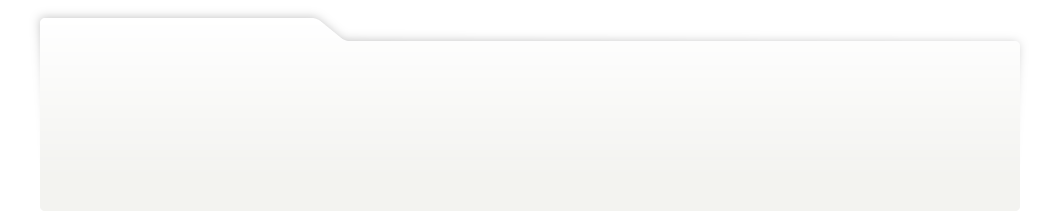
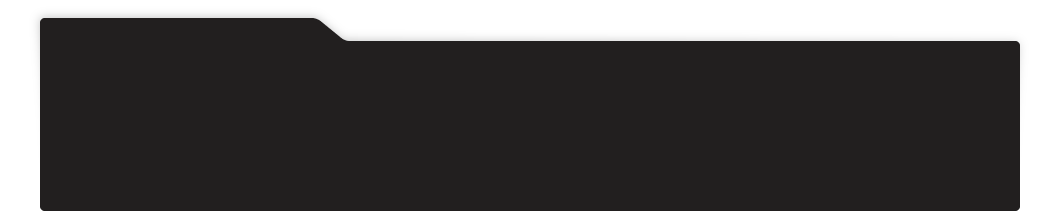
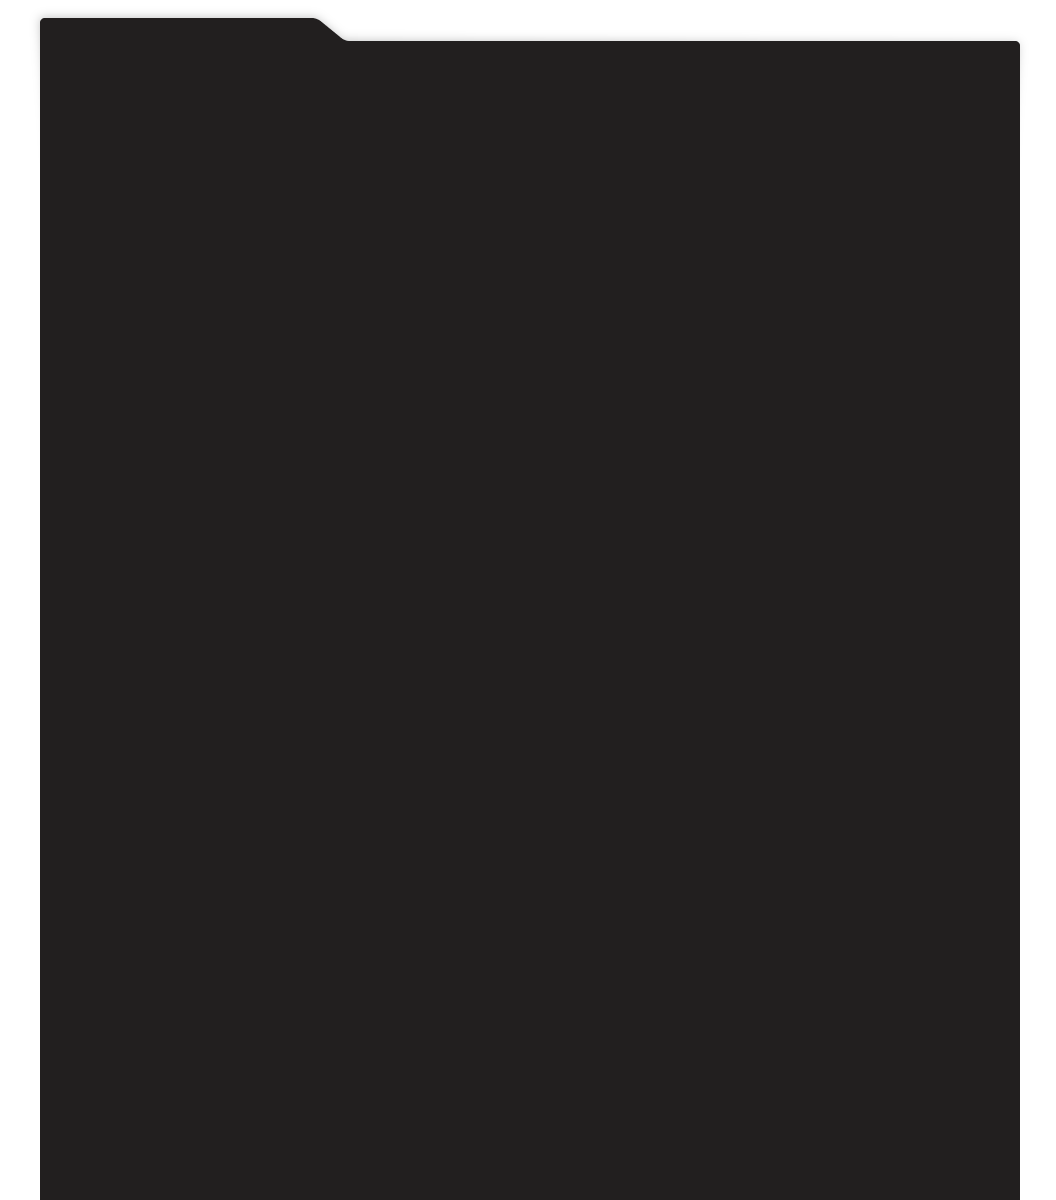
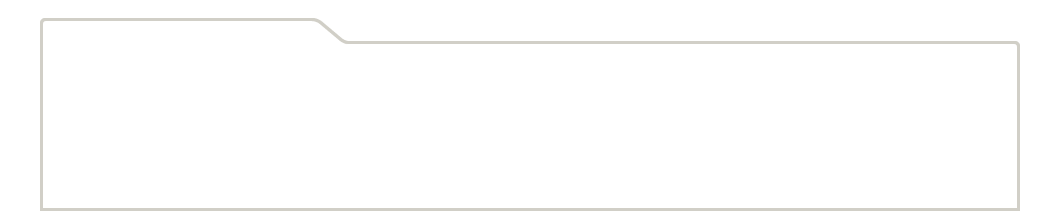
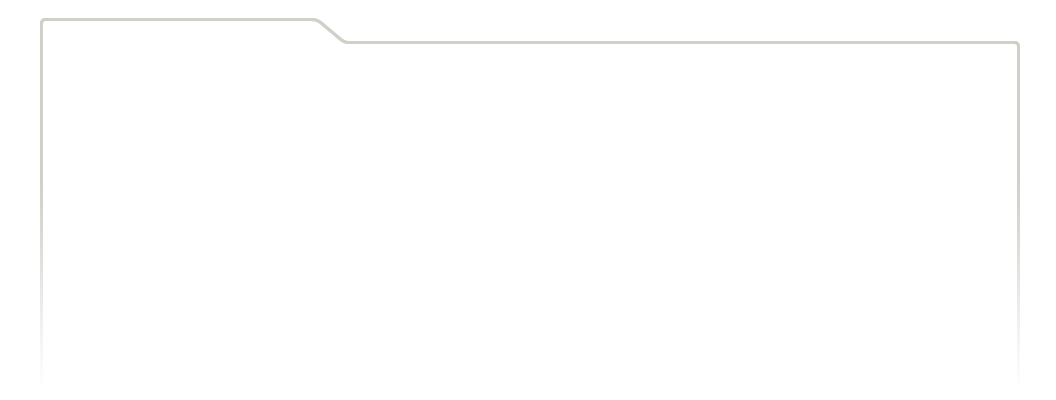
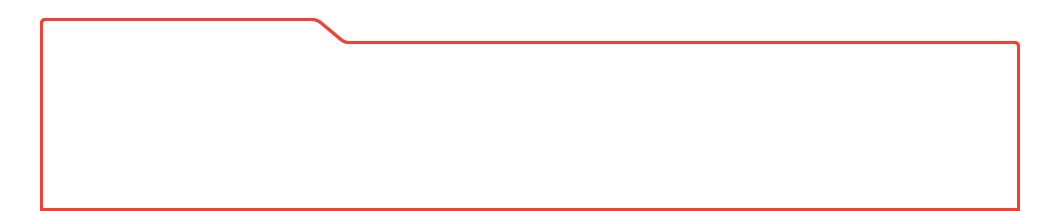
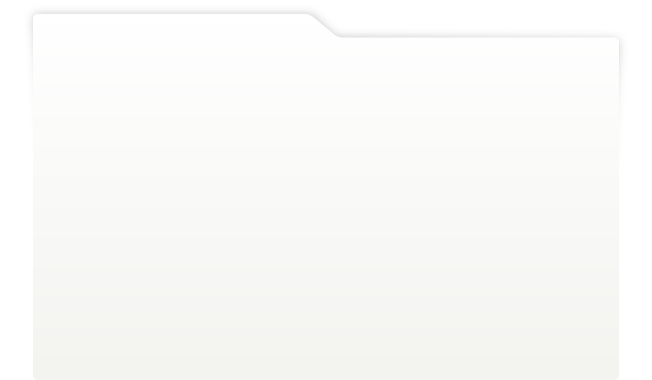
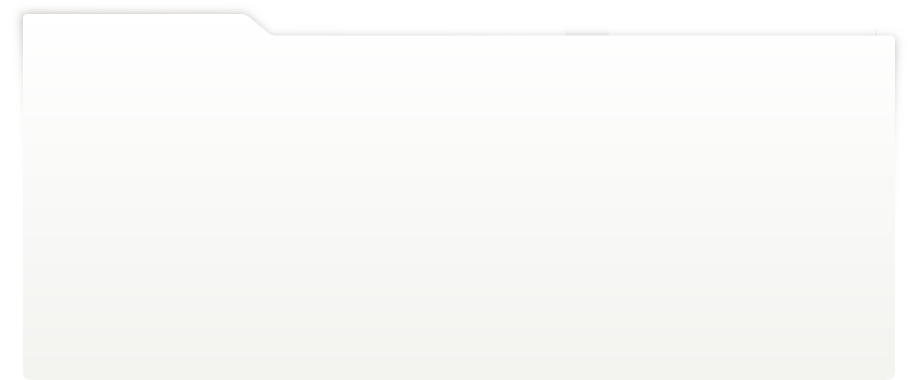
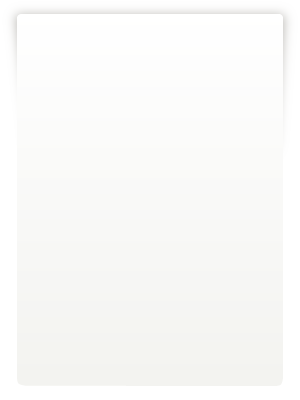
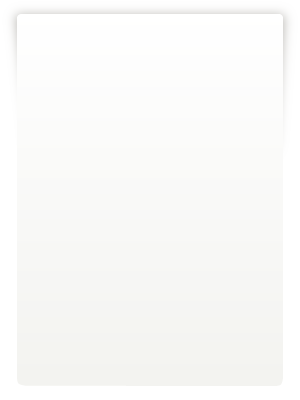
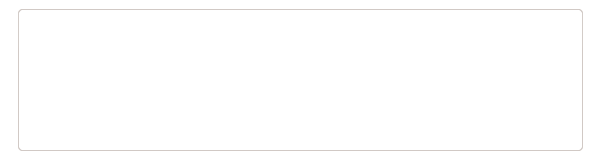
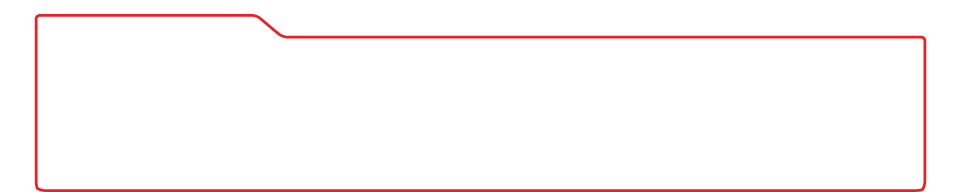
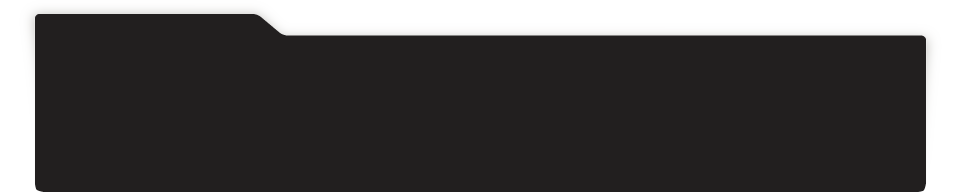
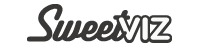
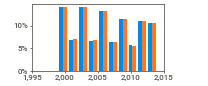
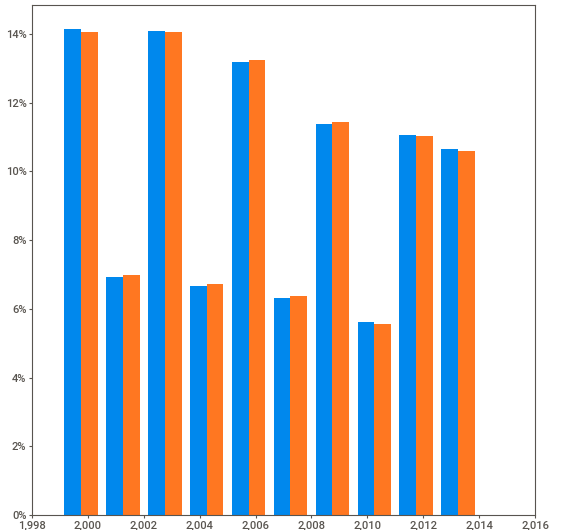
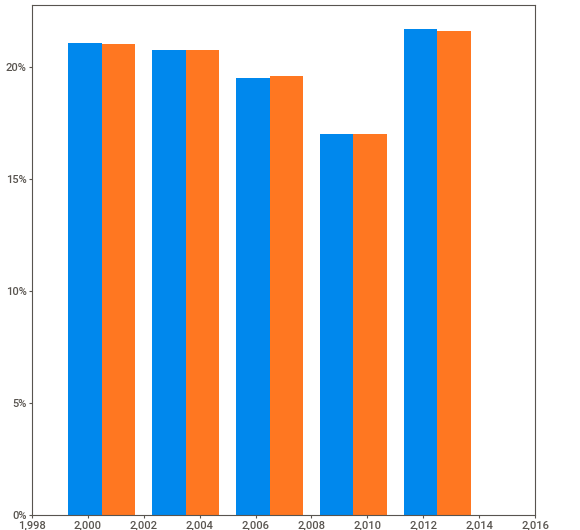
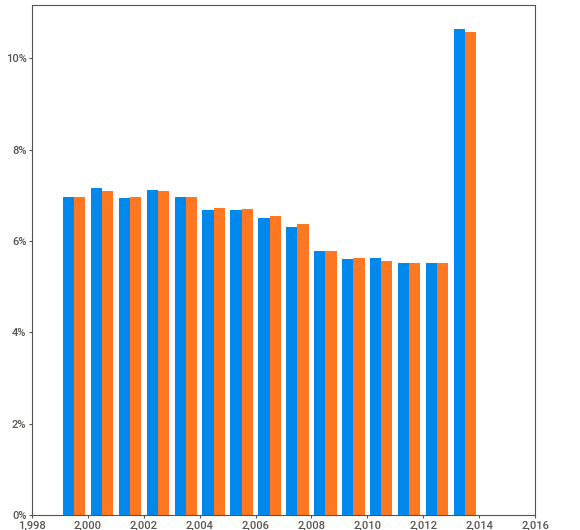
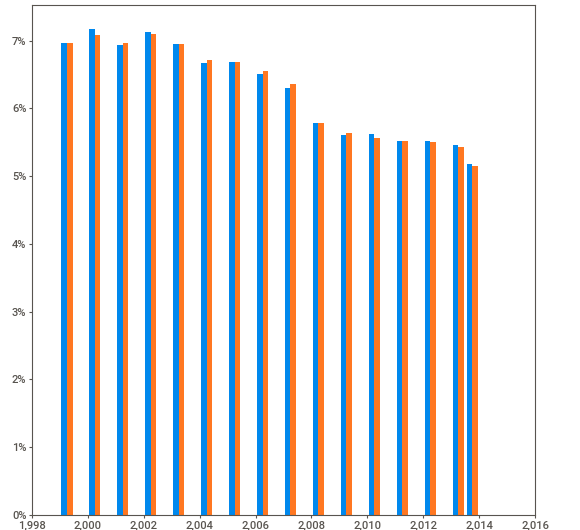
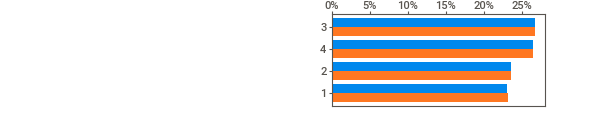
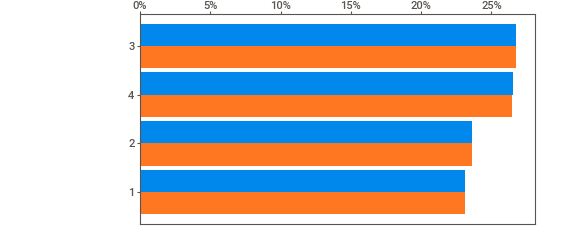
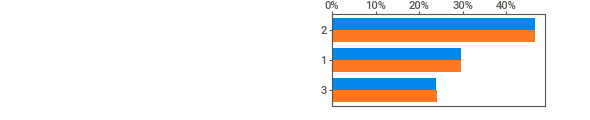
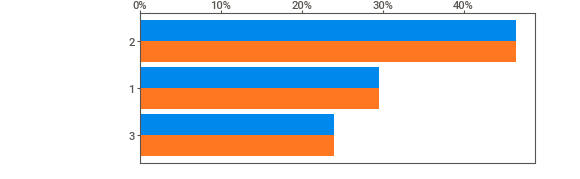
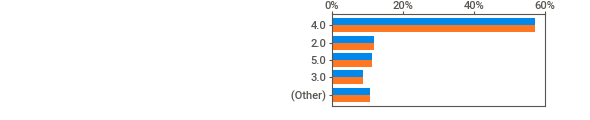
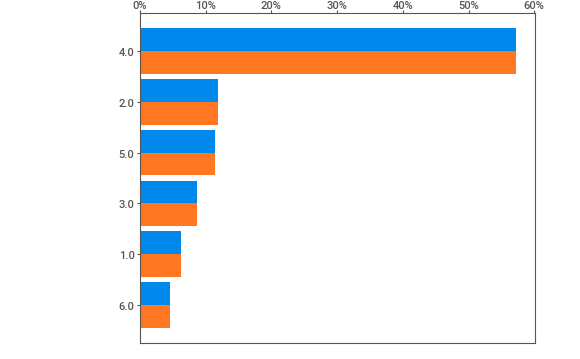
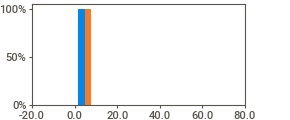
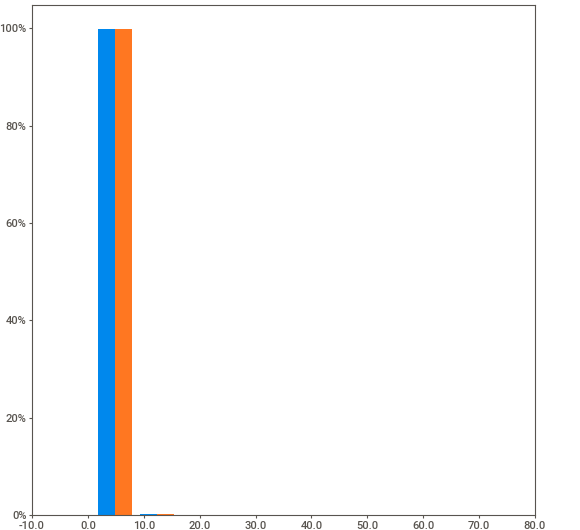
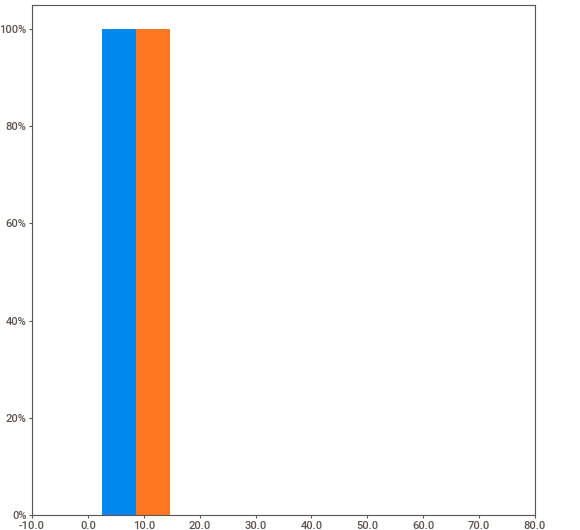
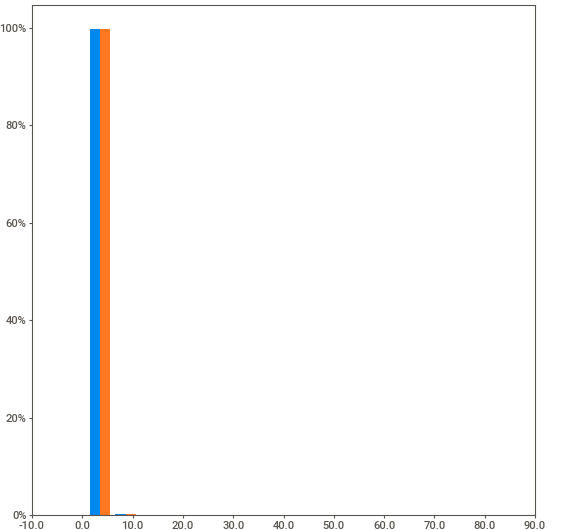
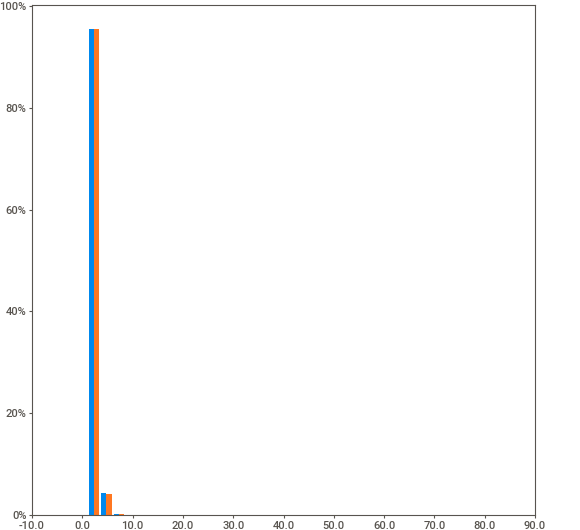
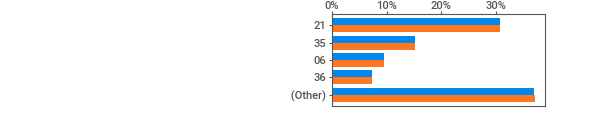
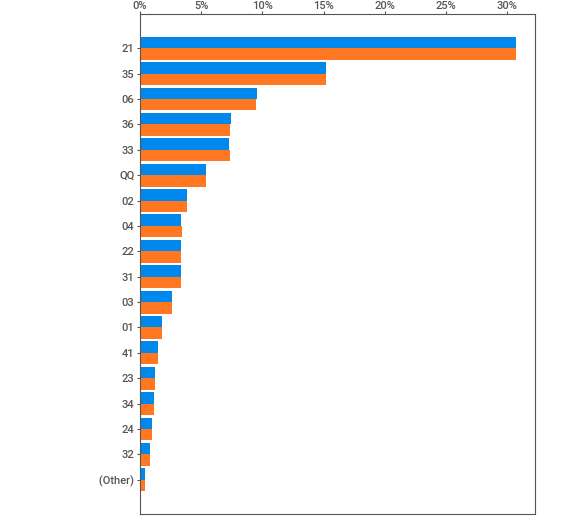
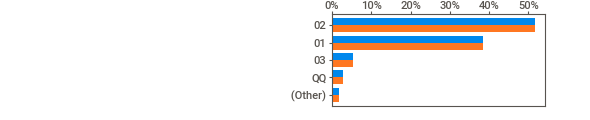
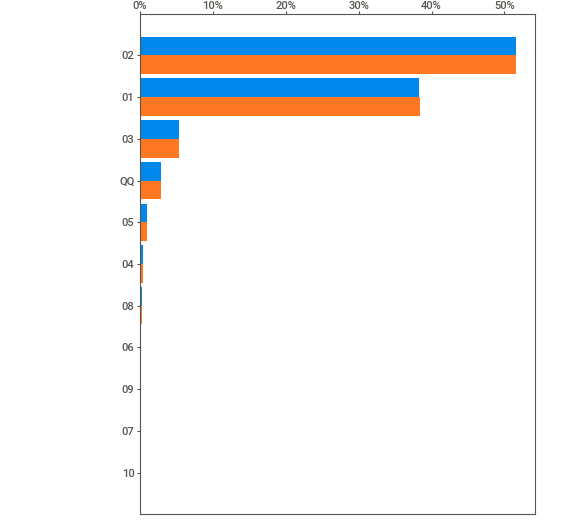
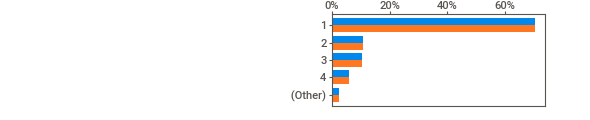
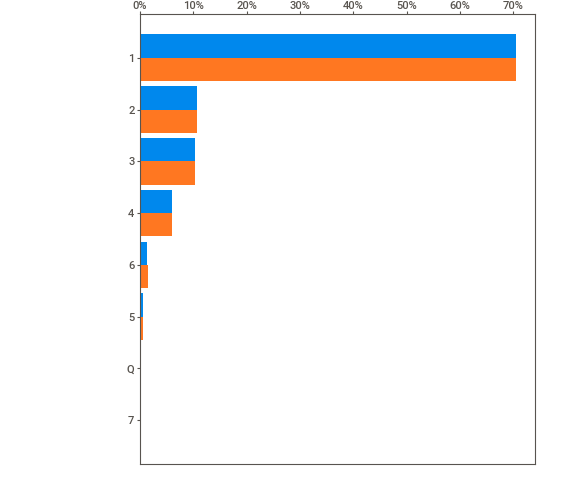
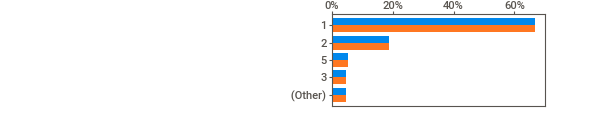
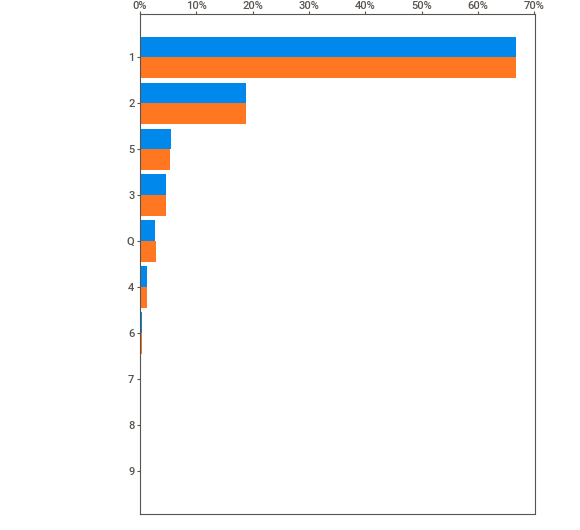
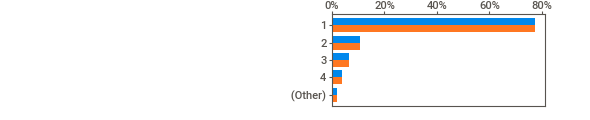
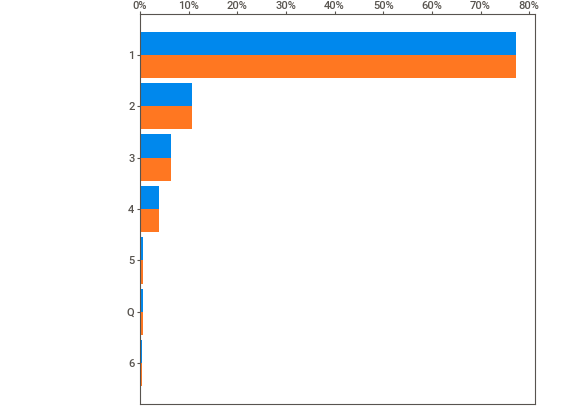
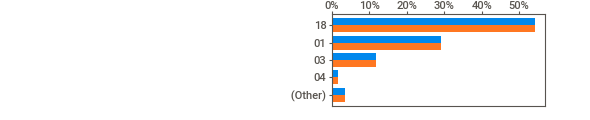
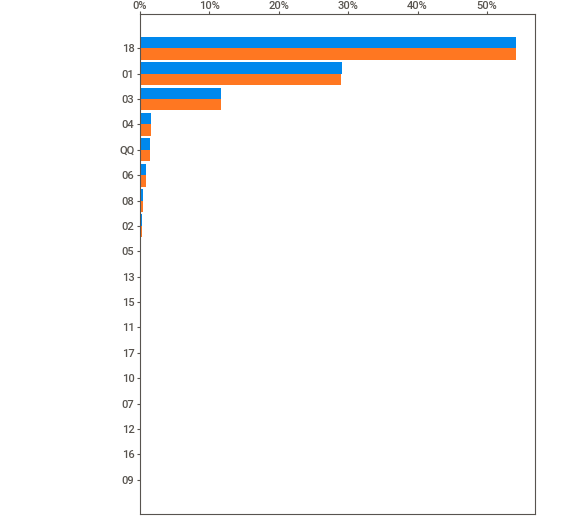
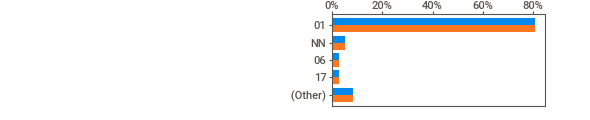
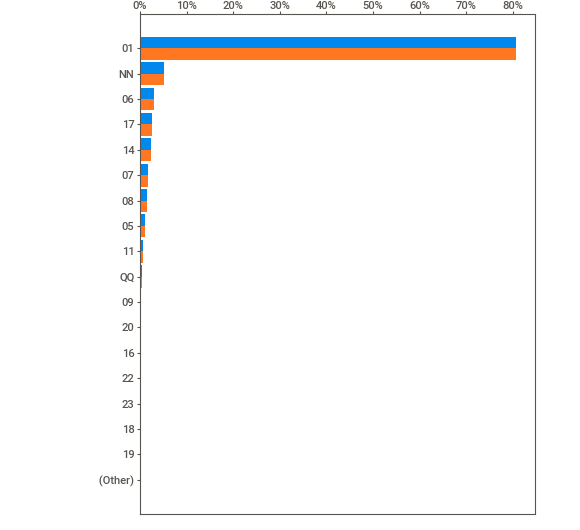
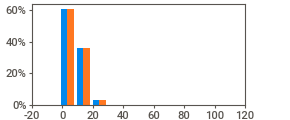
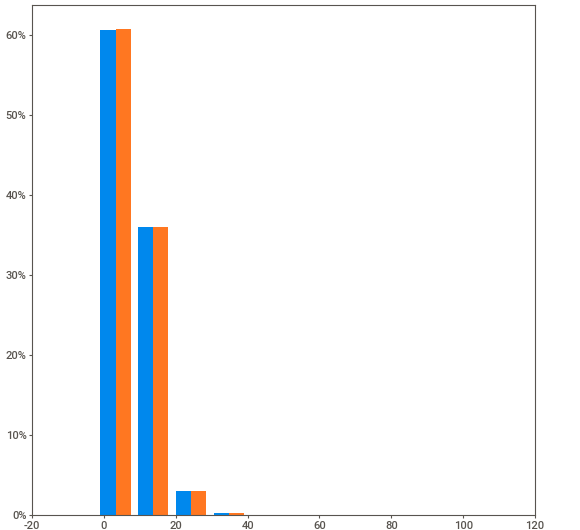
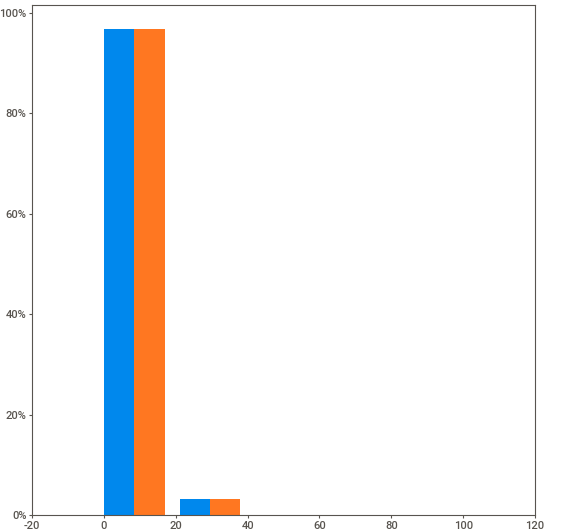
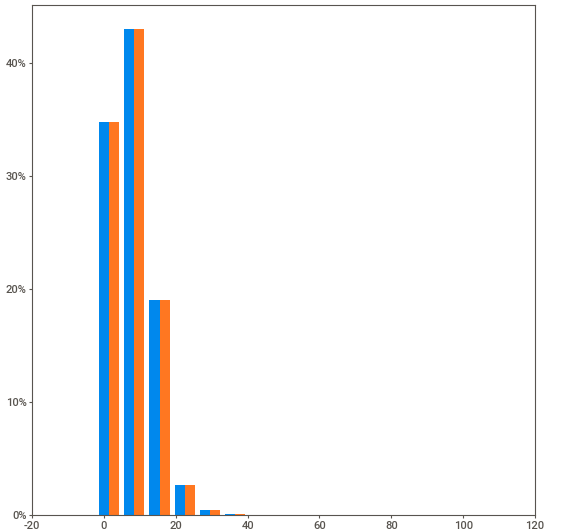
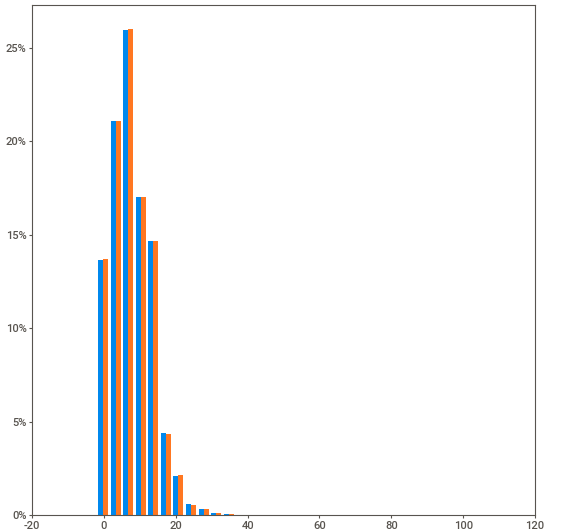
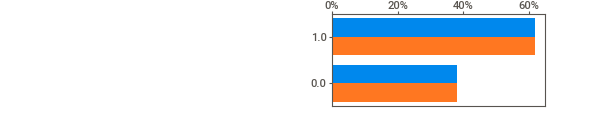
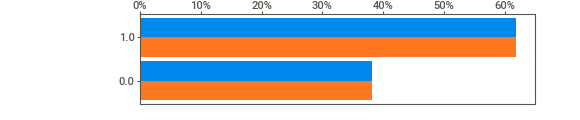
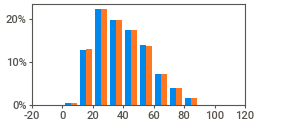
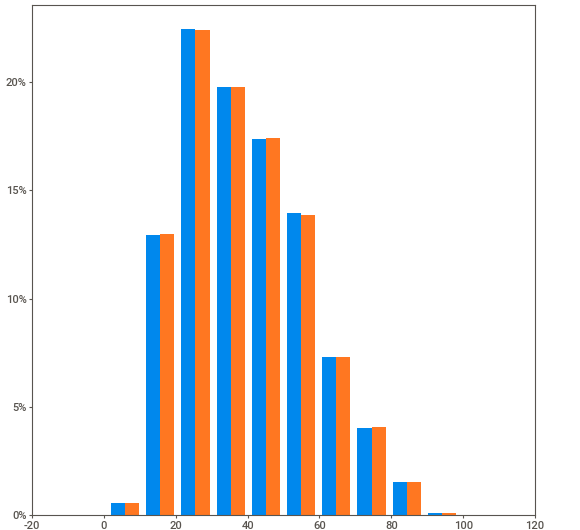
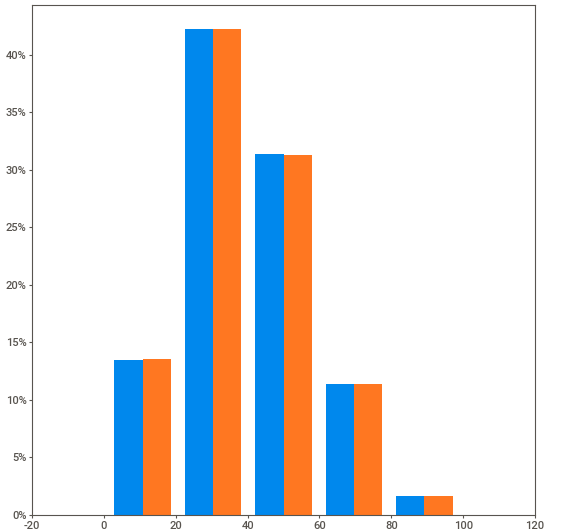
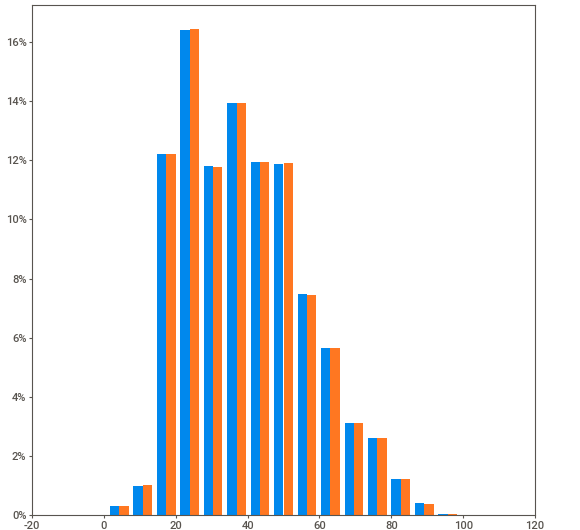
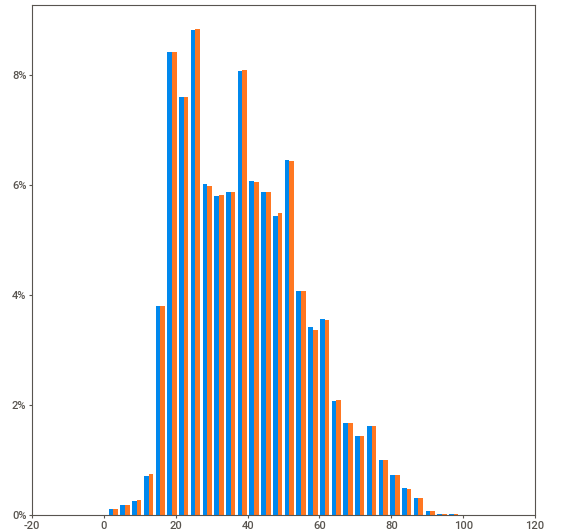
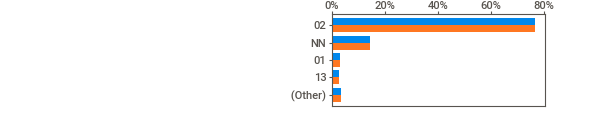
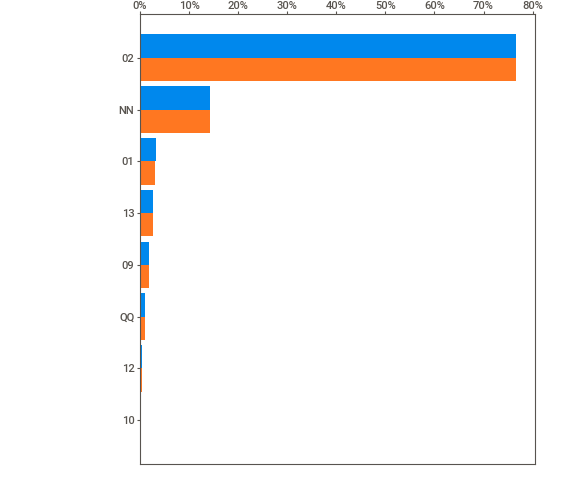
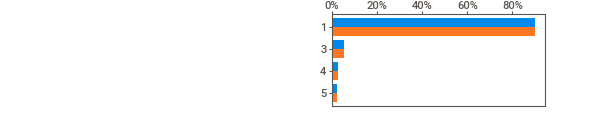
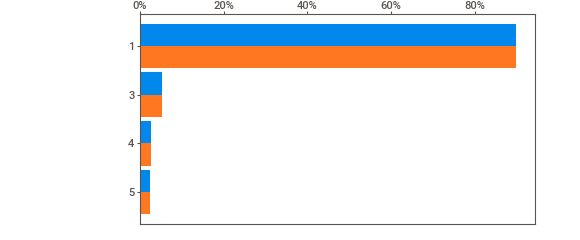
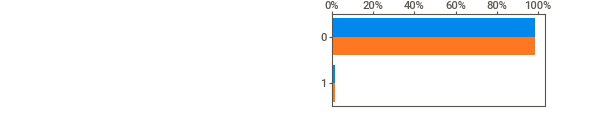
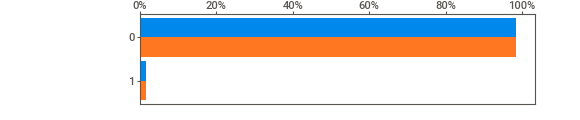
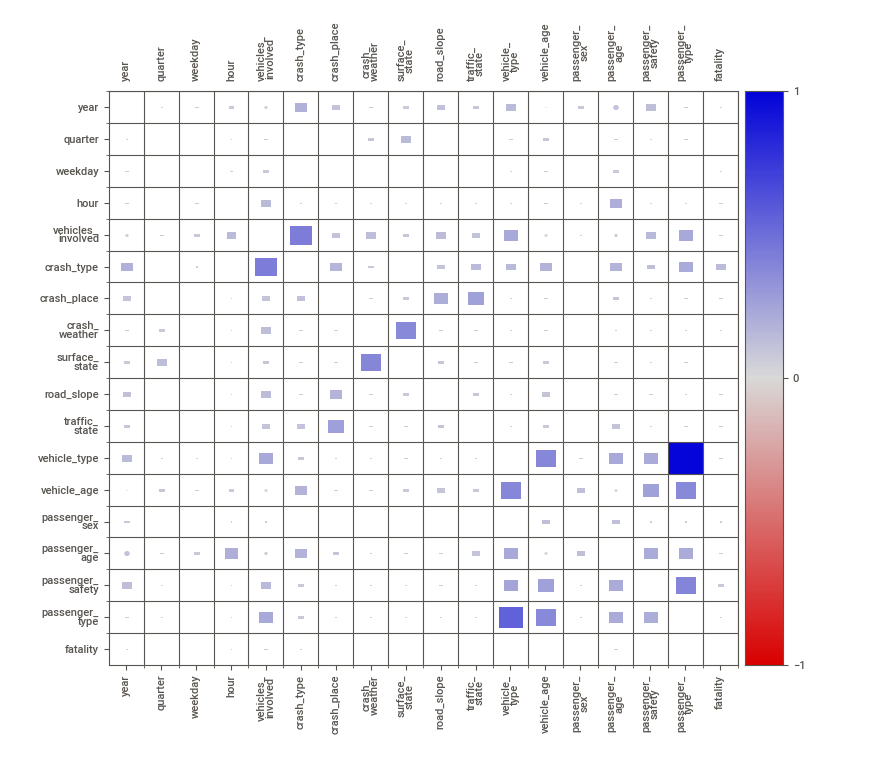
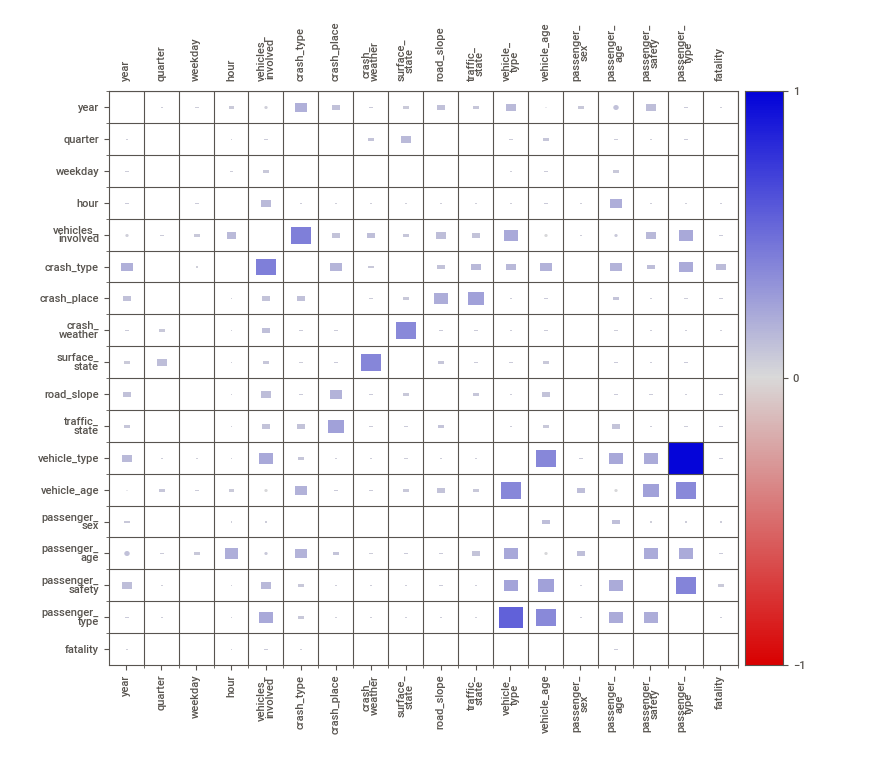

In [16]:
feature_config = sv.FeatureConfig() #,force_text=[""]
my_report = sv.compare([train, "Train"], [test, "Test"], feat_cfg=feature_config)
my_report.show_notebook( 
            layout='widescreen', 
            scale=None)

## Real Data & Synthetic Data Comparison

In [7]:
real_data = test

                                             |          | [  0%]   00:00 -> (? left)


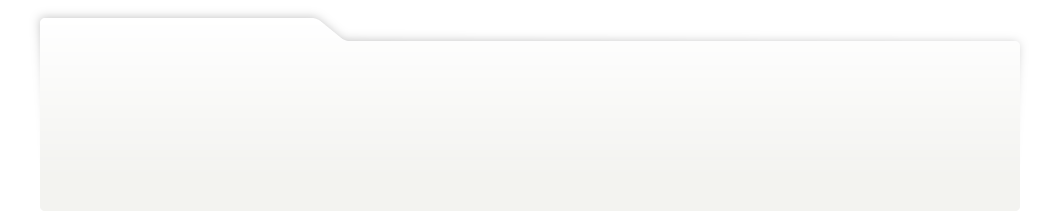
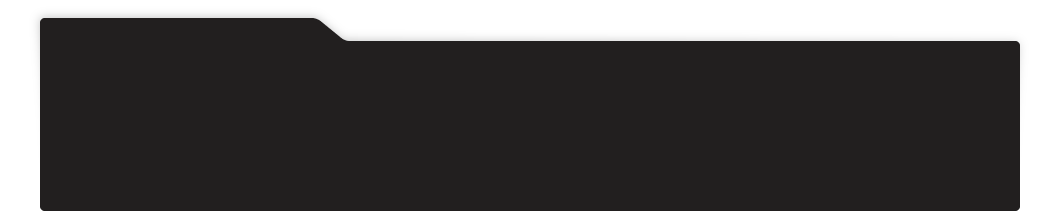
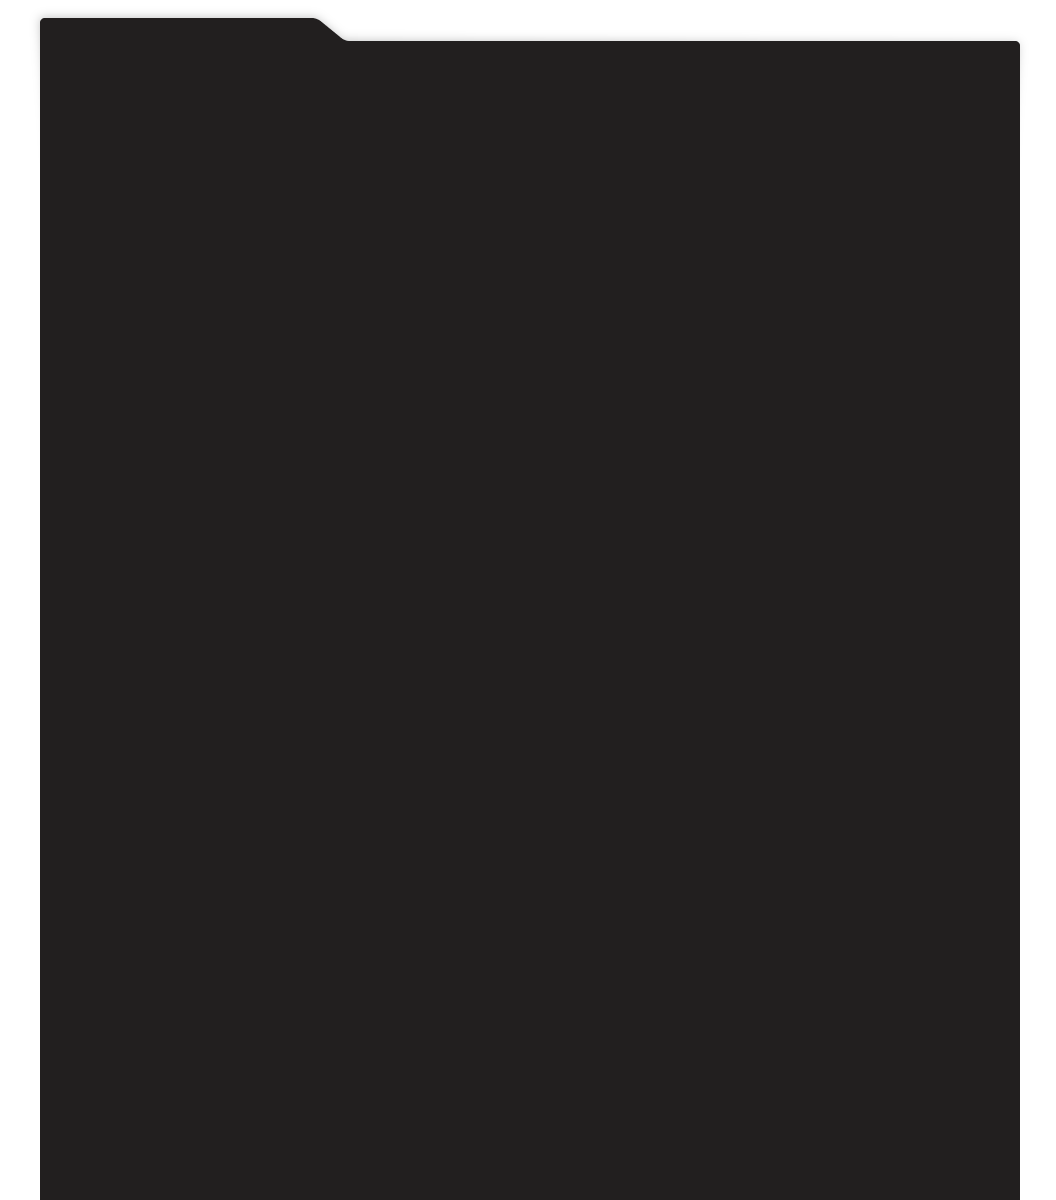
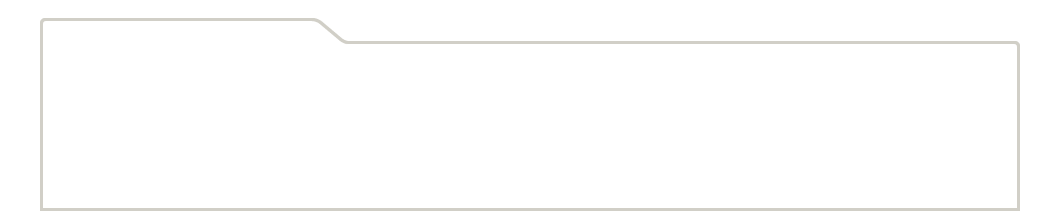
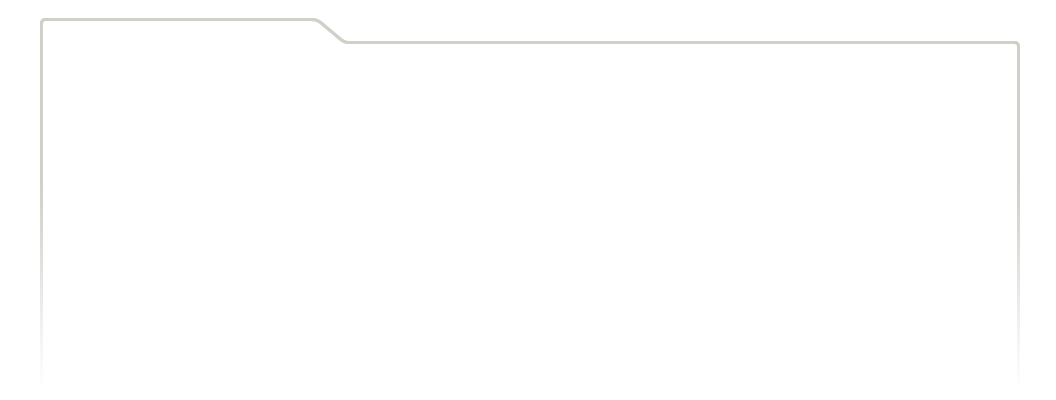
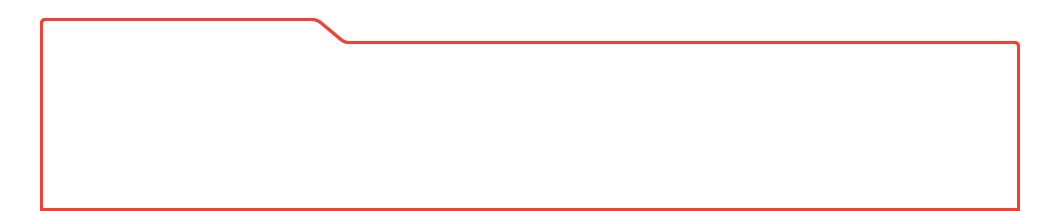
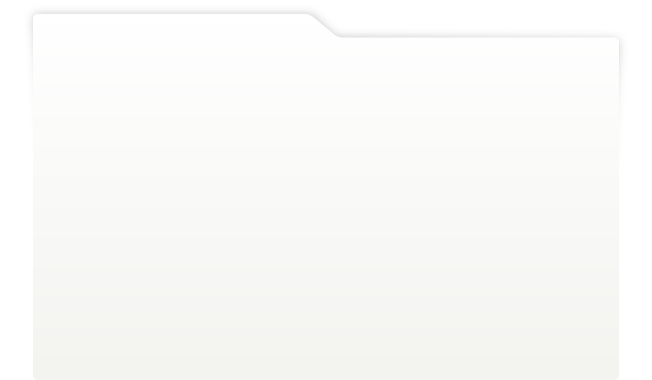
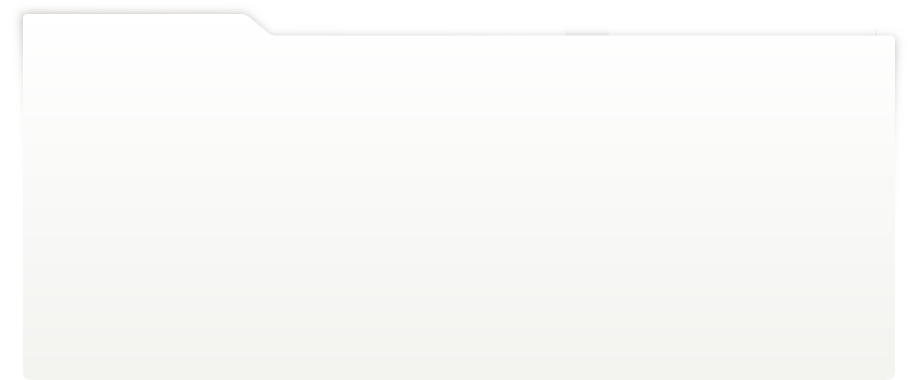
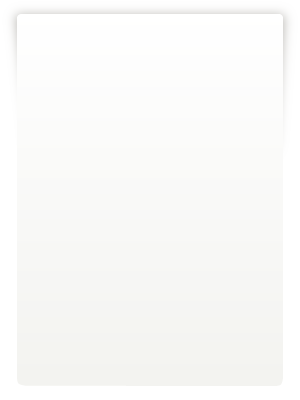
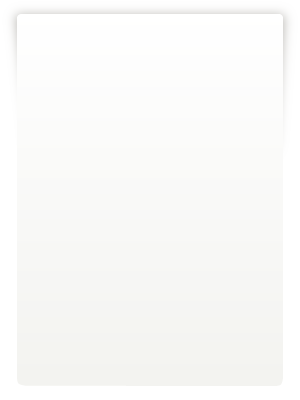
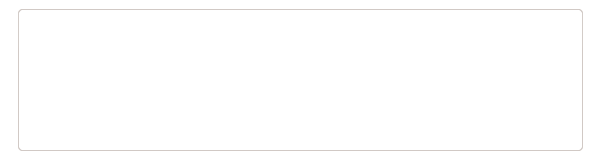
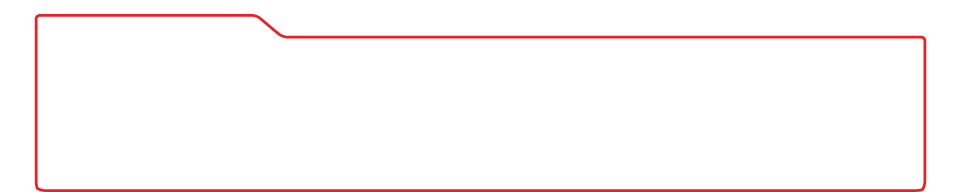
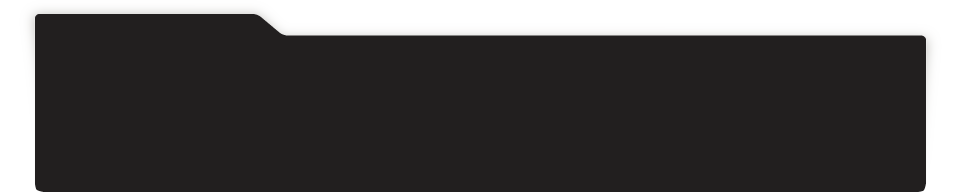
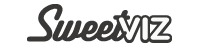
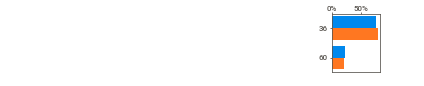
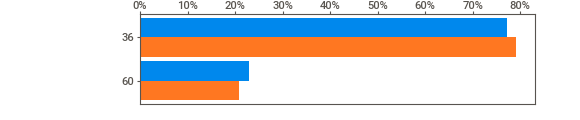
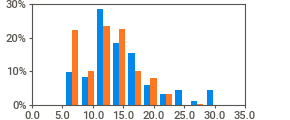
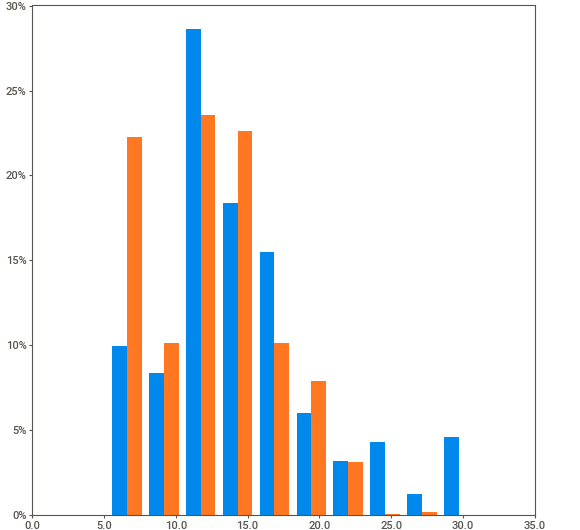
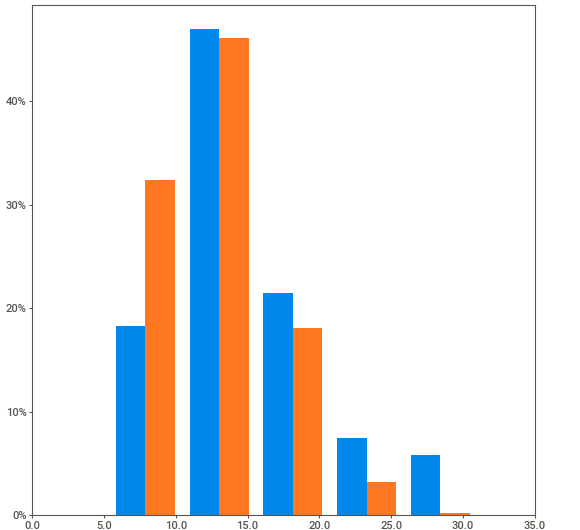
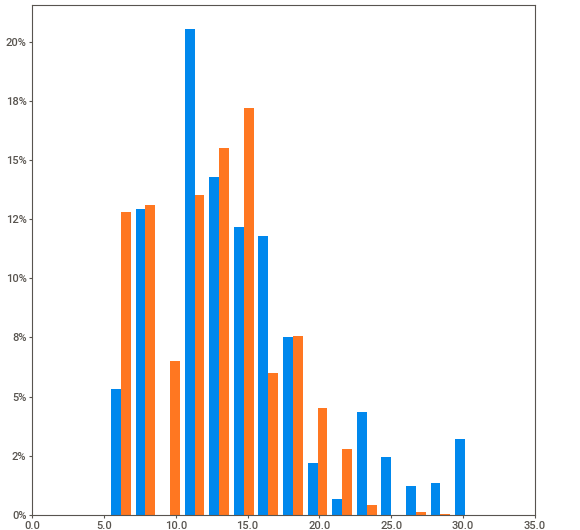
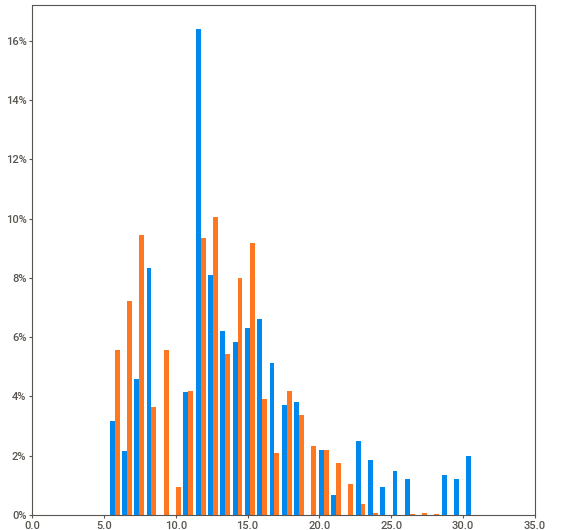
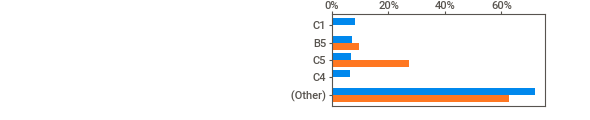
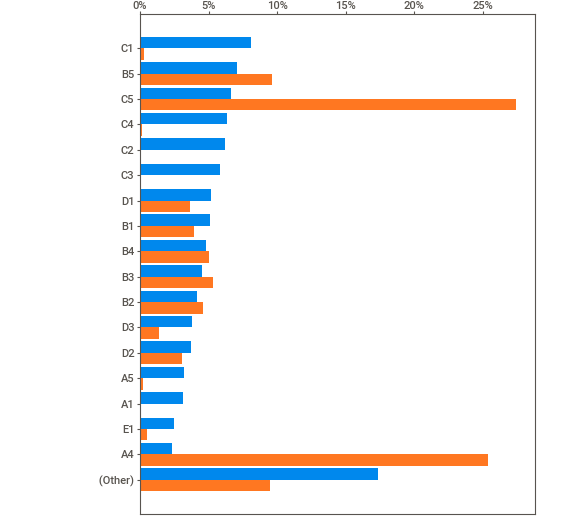
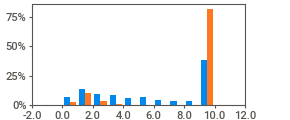
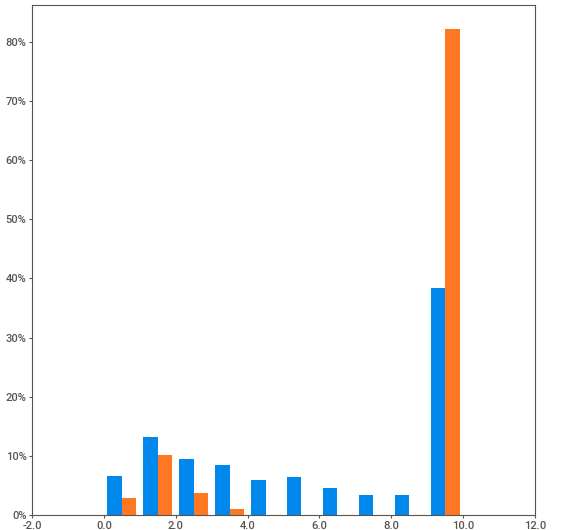
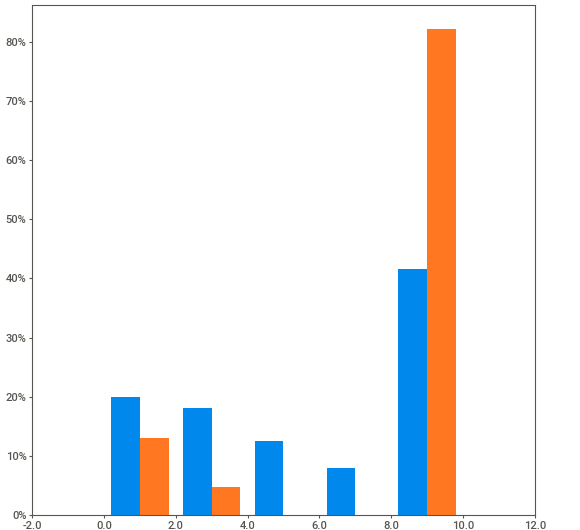
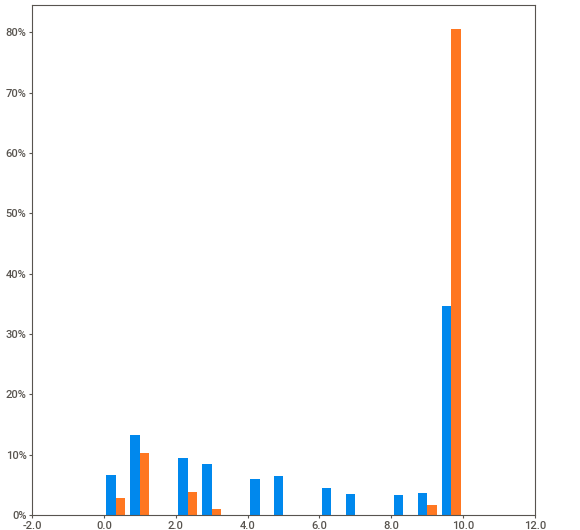
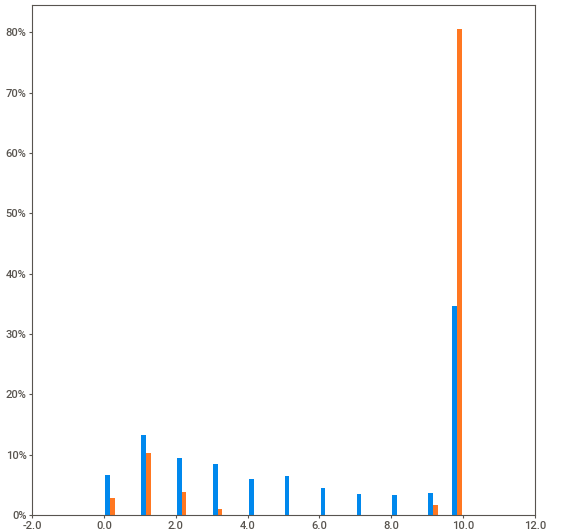
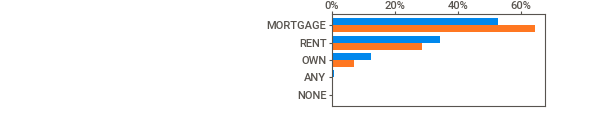
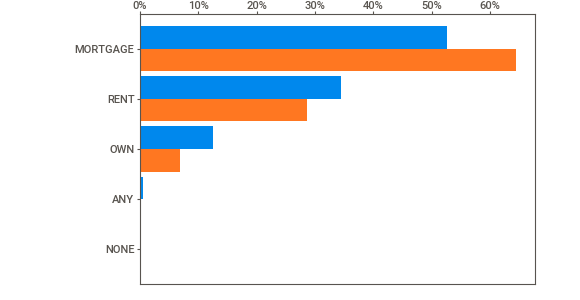
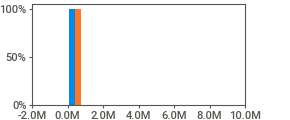
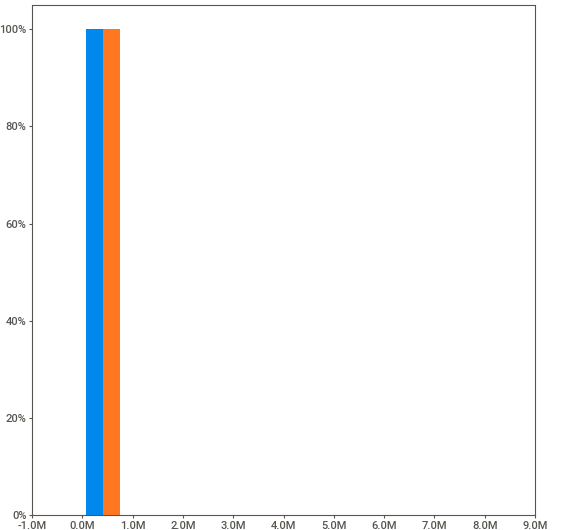
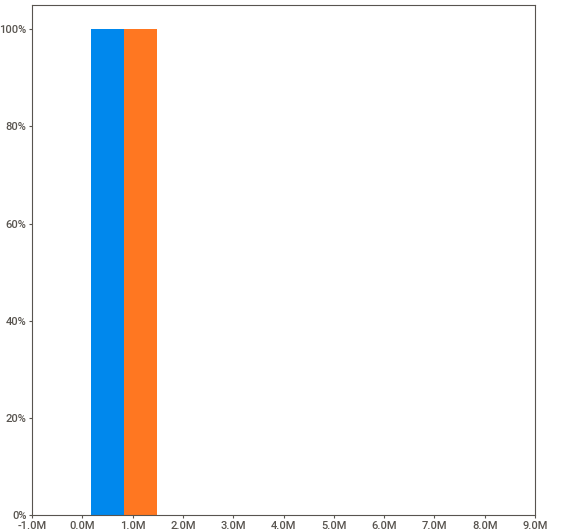
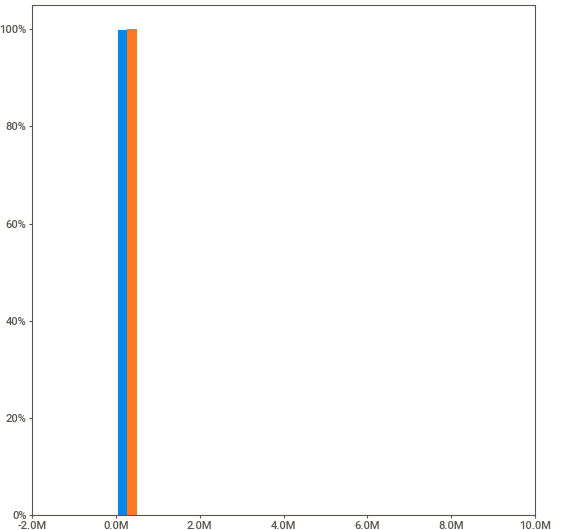
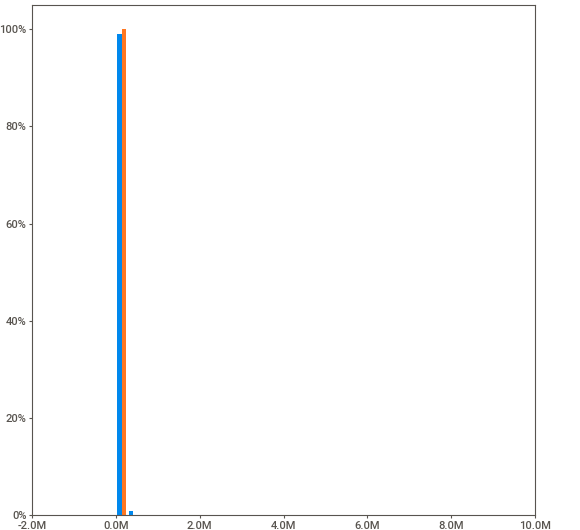
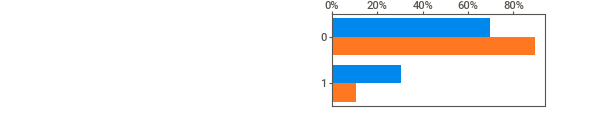
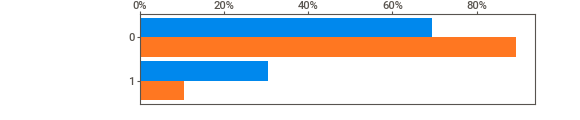
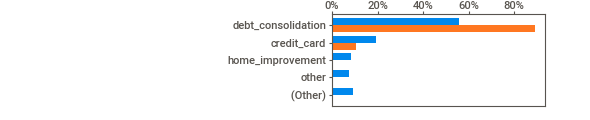
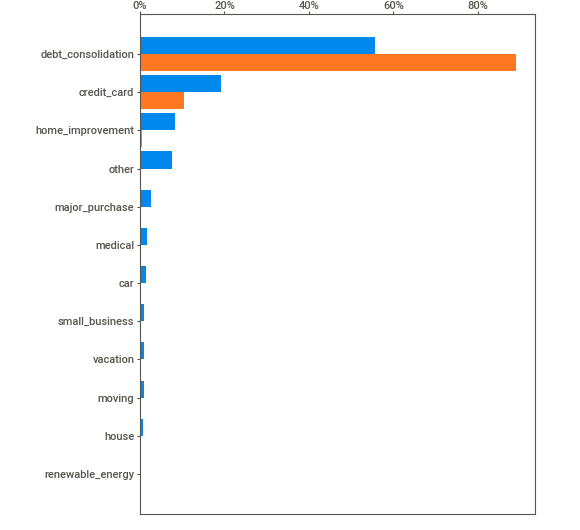
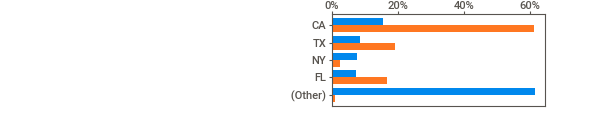
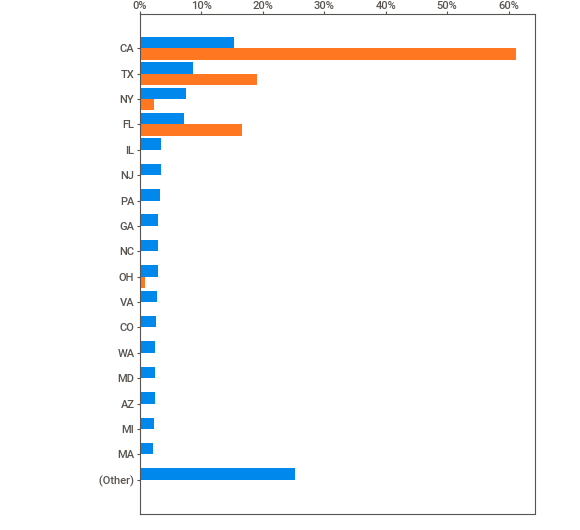
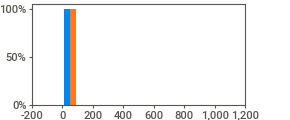
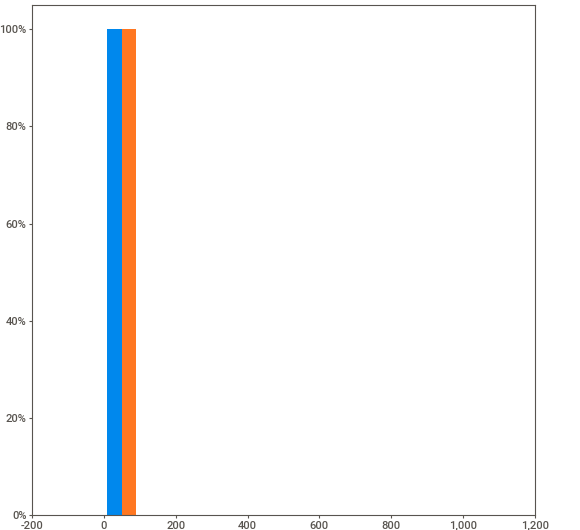
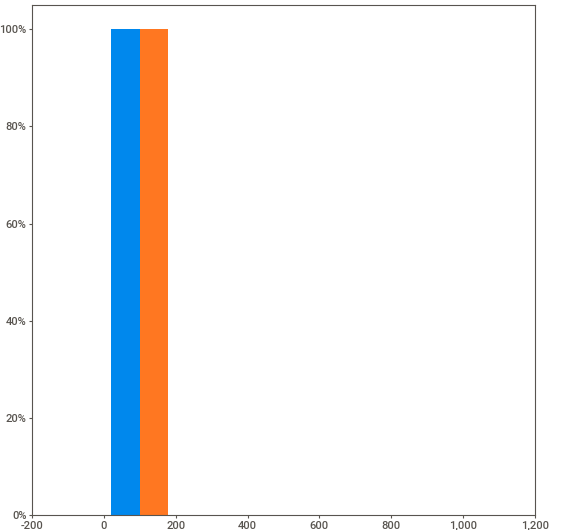
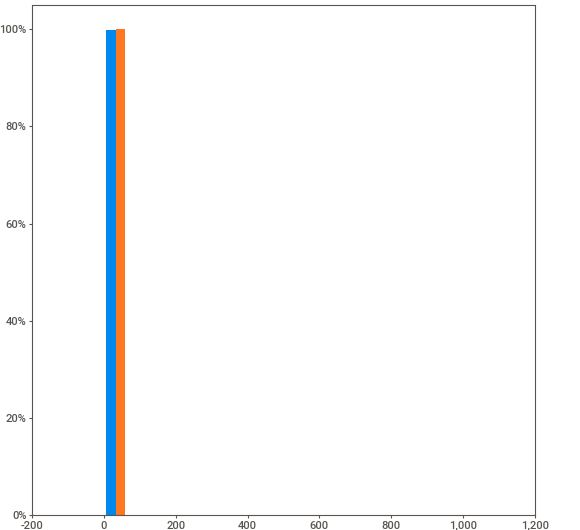
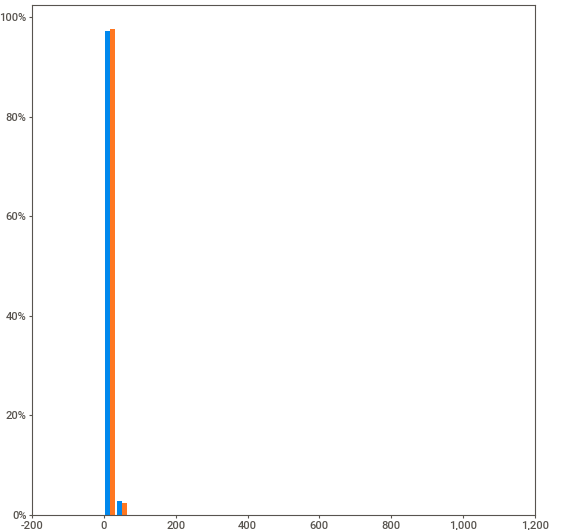
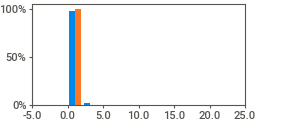
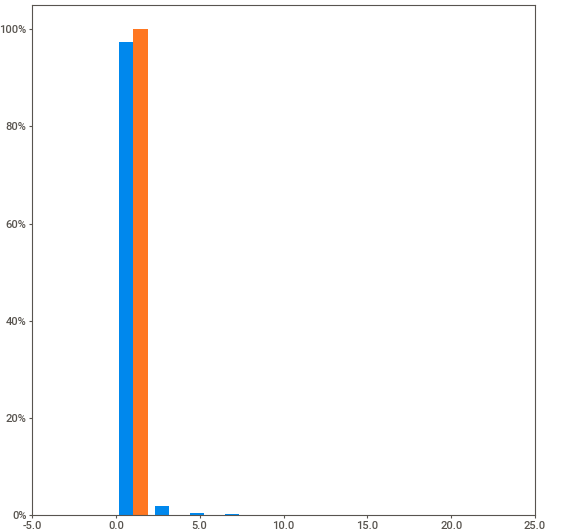
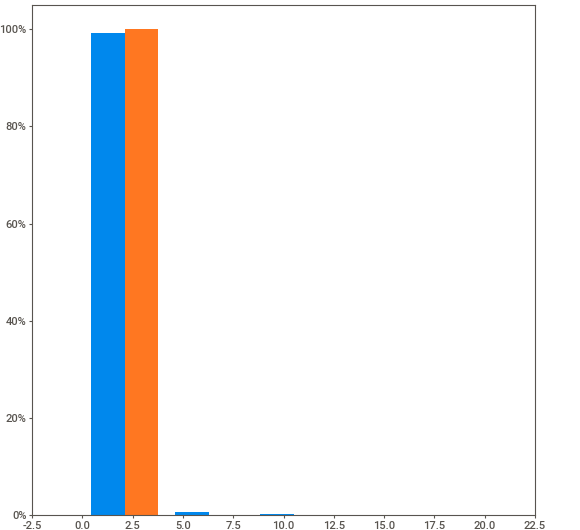
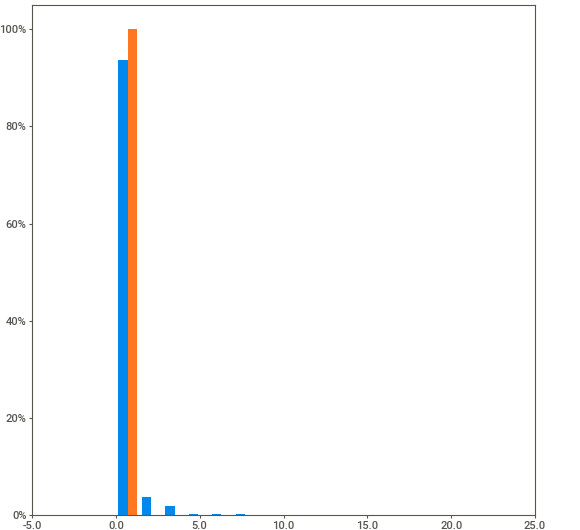
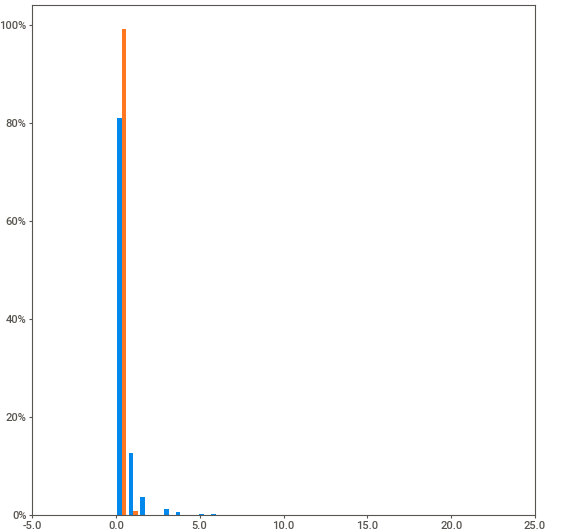
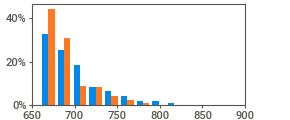
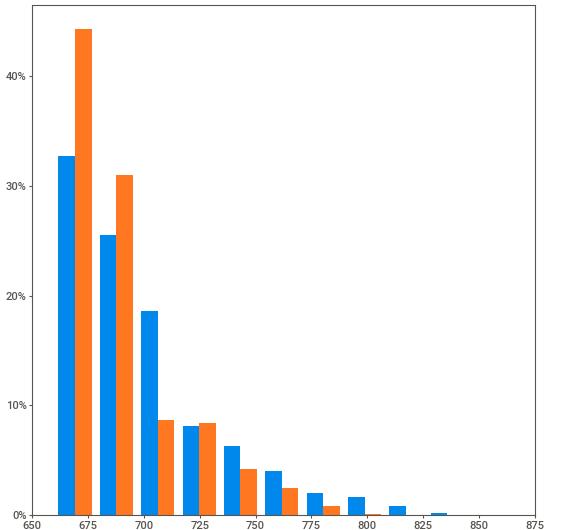
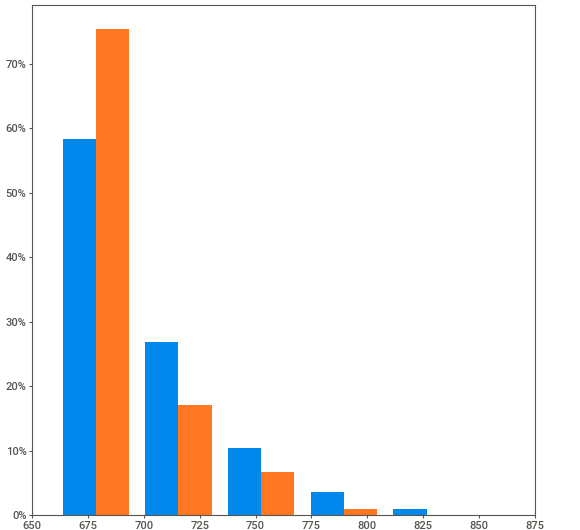
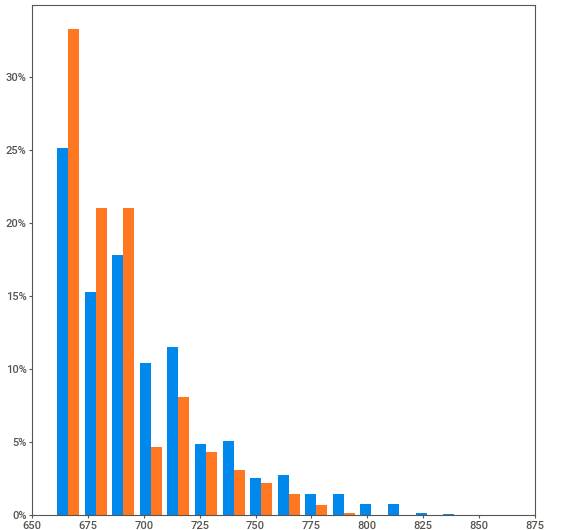
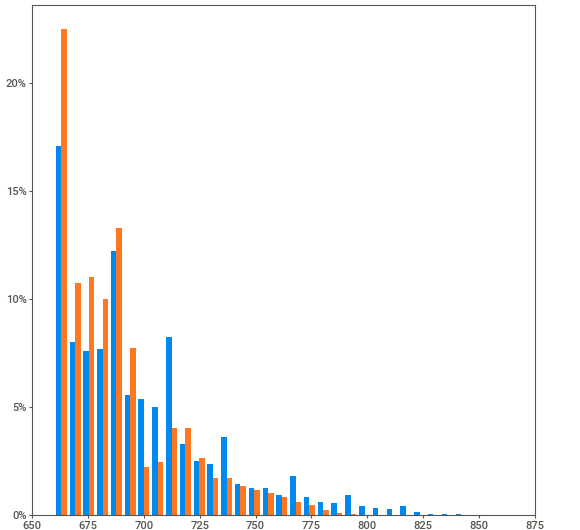
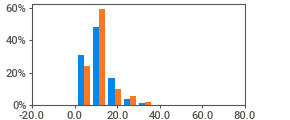
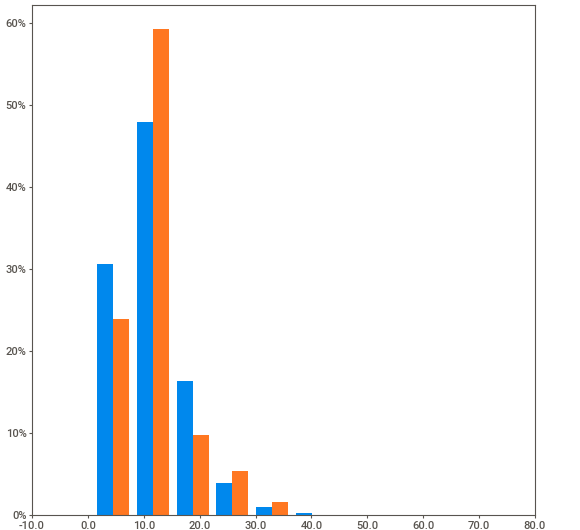
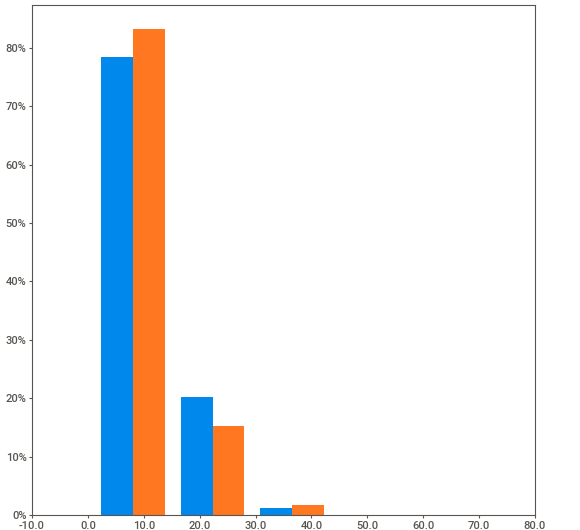
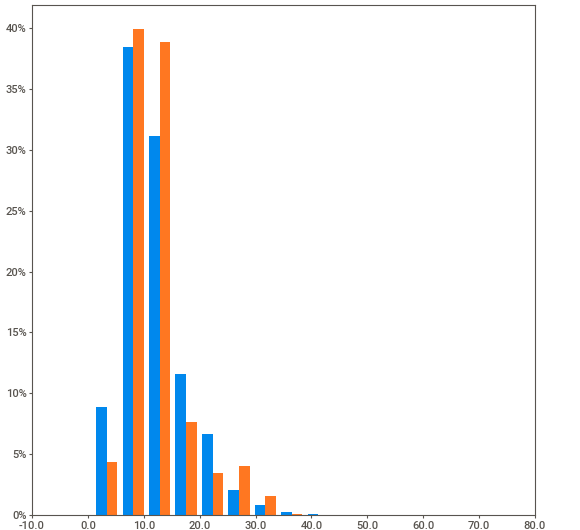
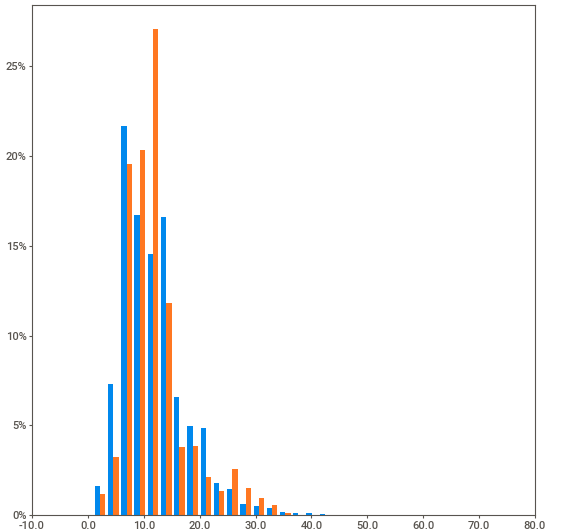
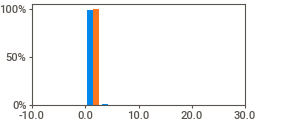
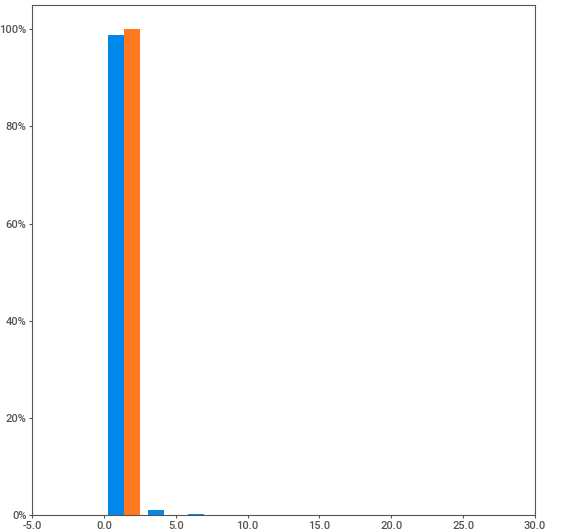
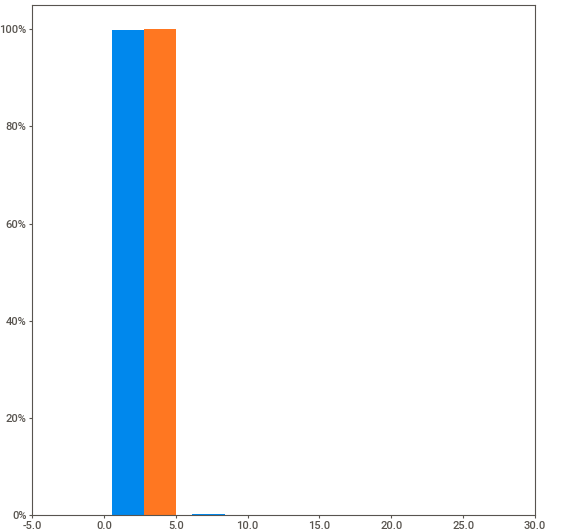
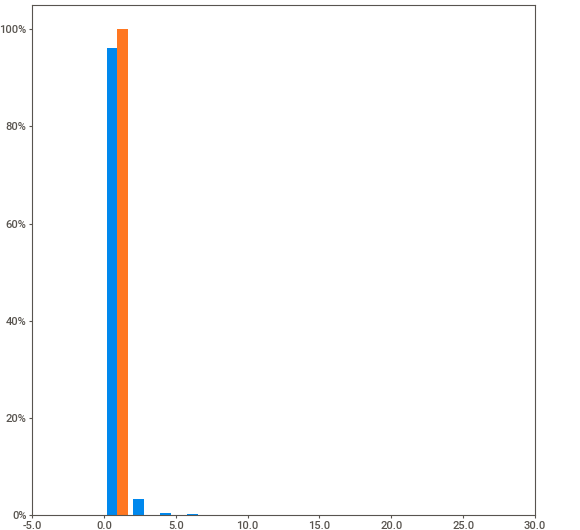
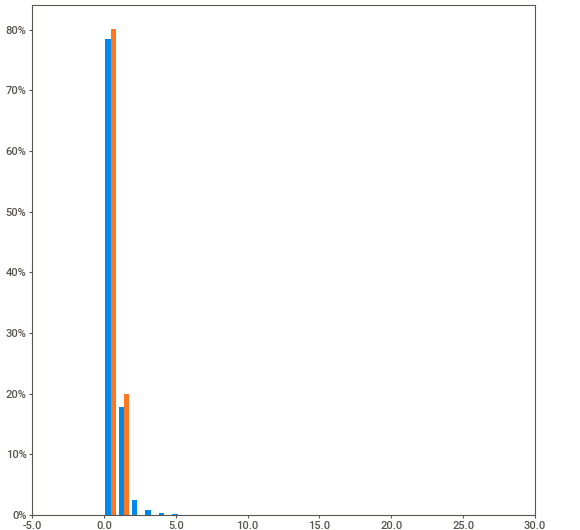
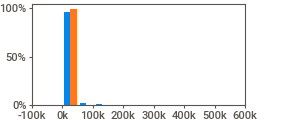
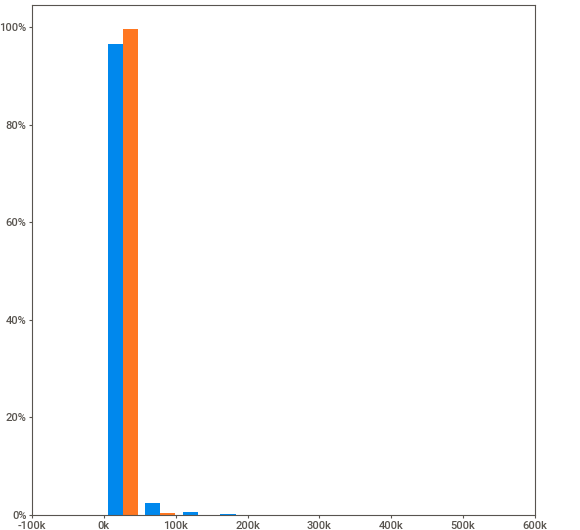
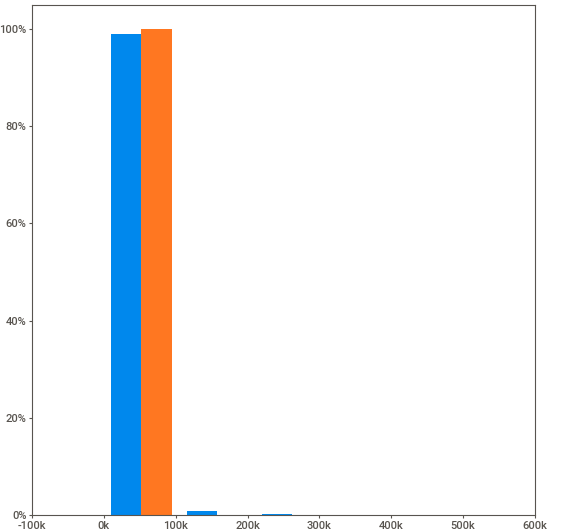
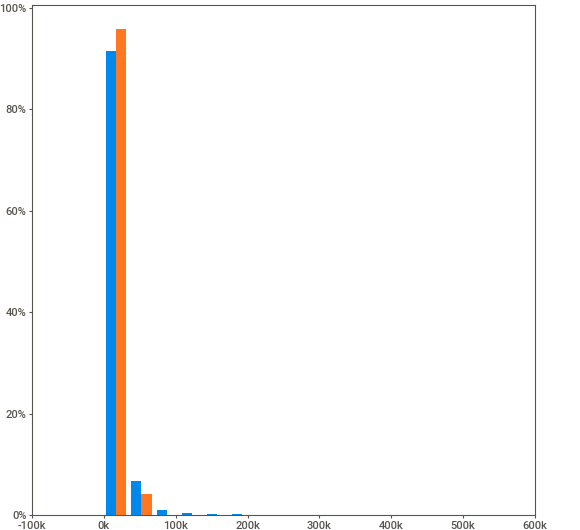
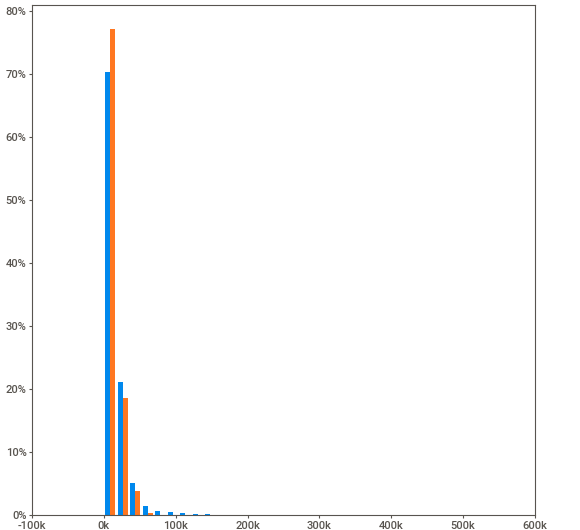
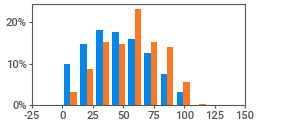
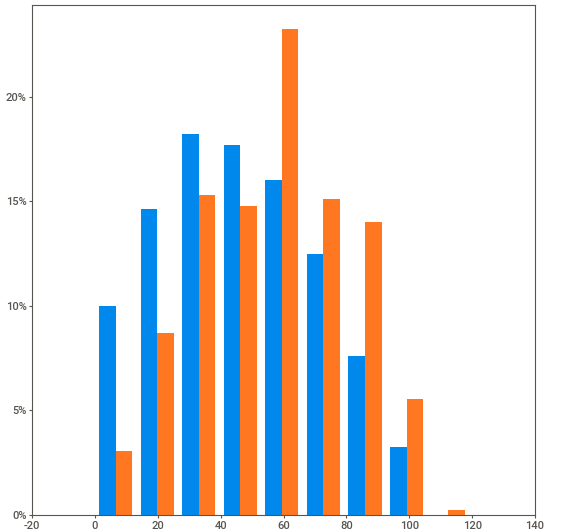
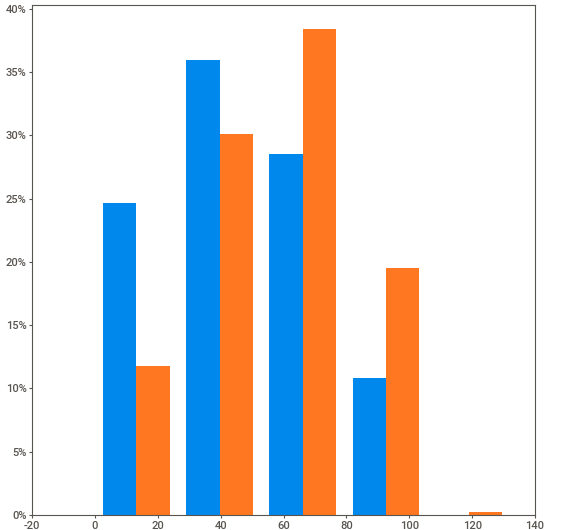
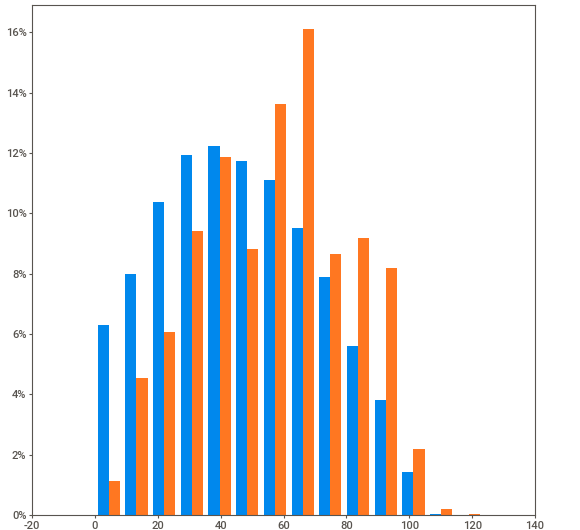
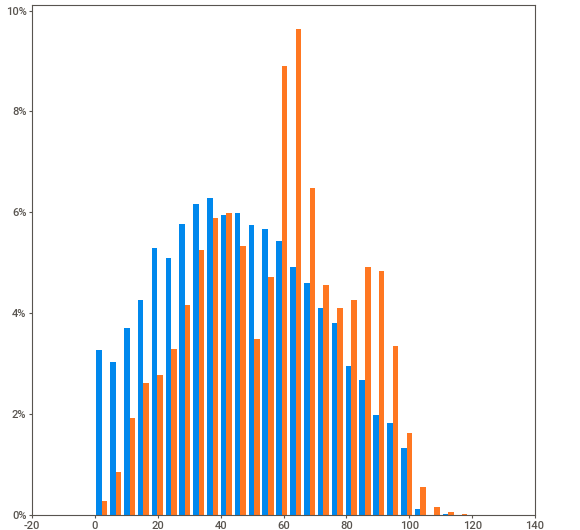
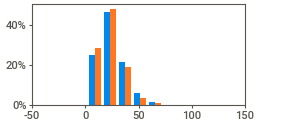
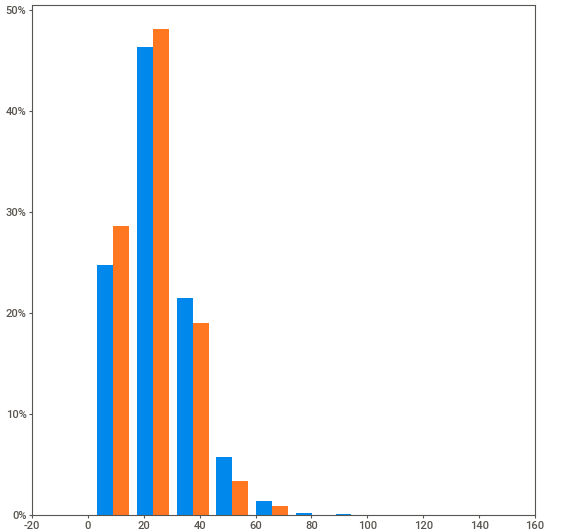
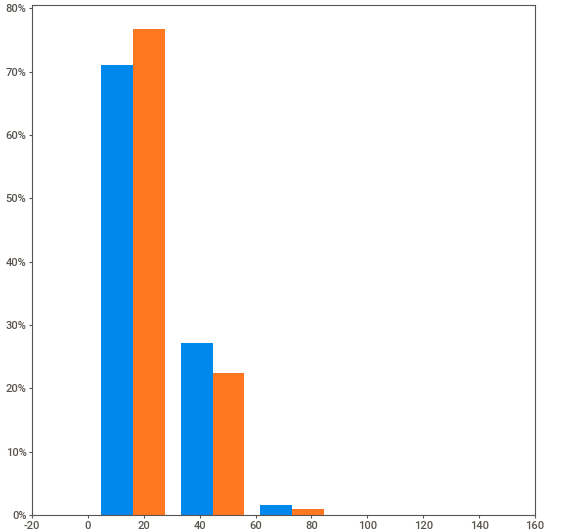
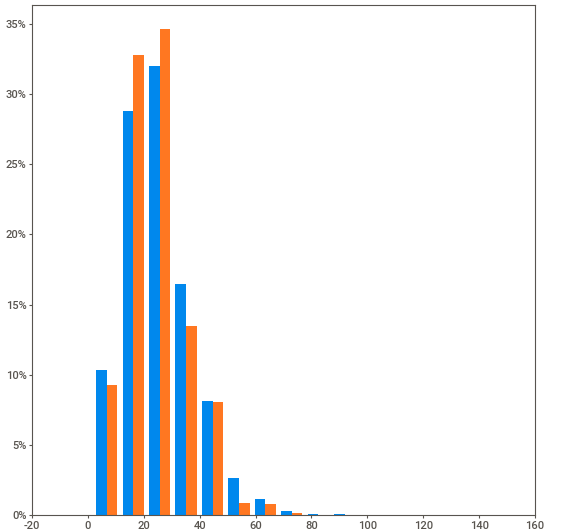
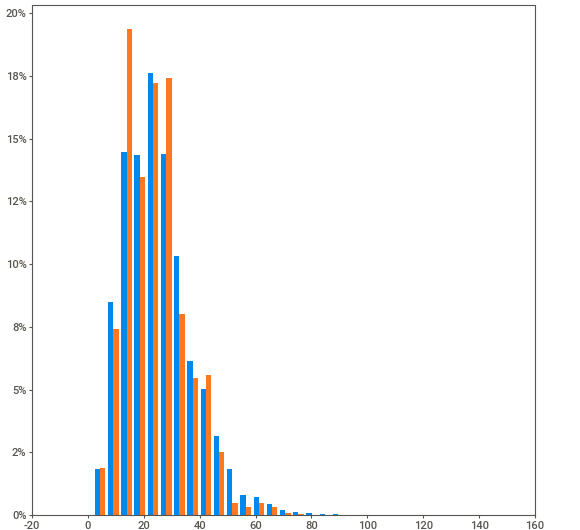
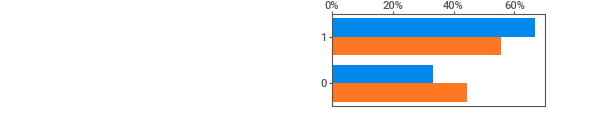
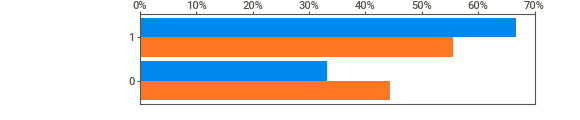
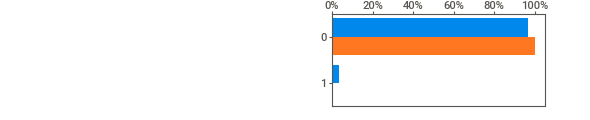
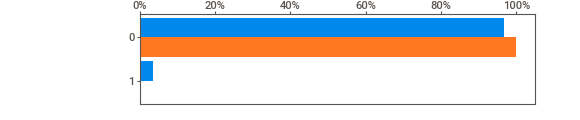
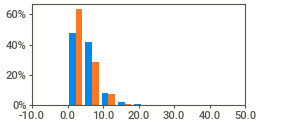
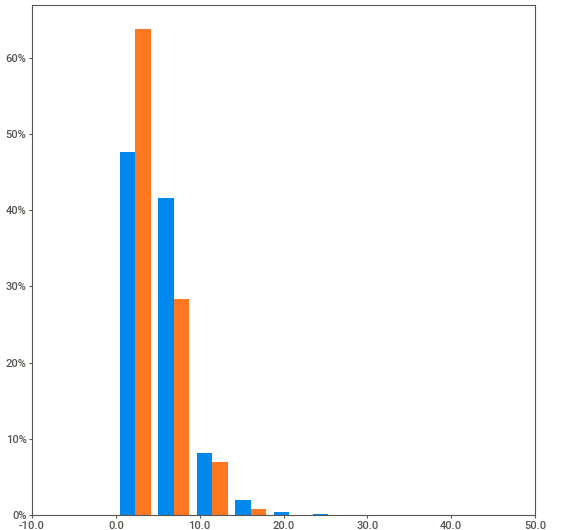
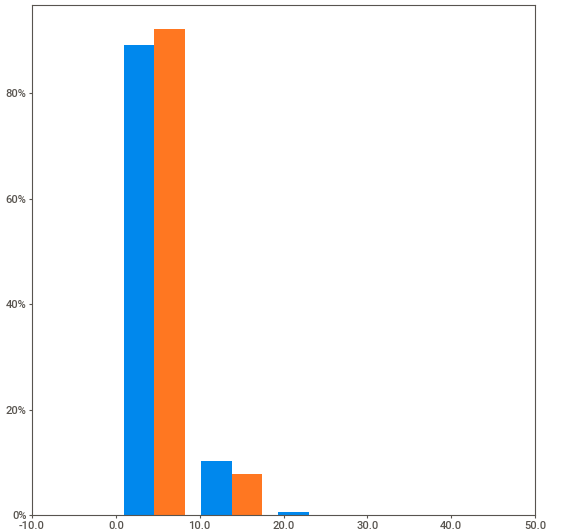
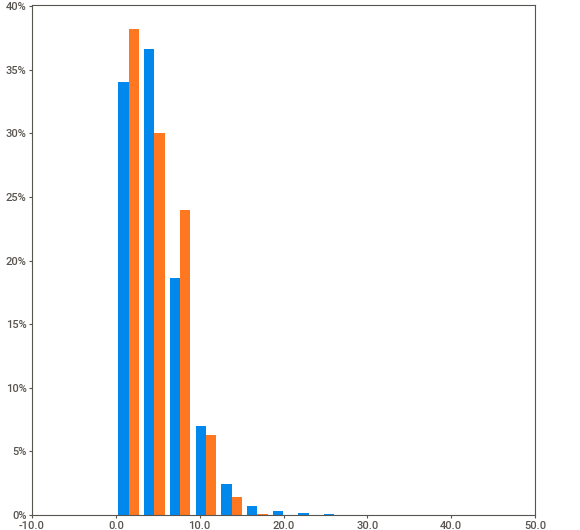
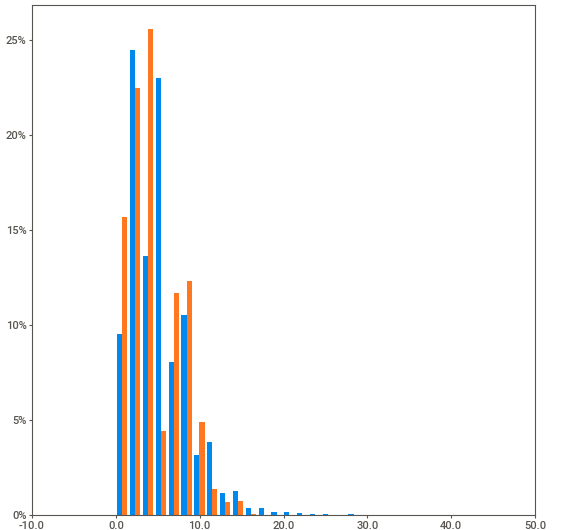
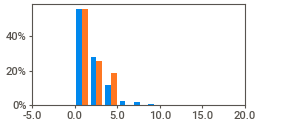
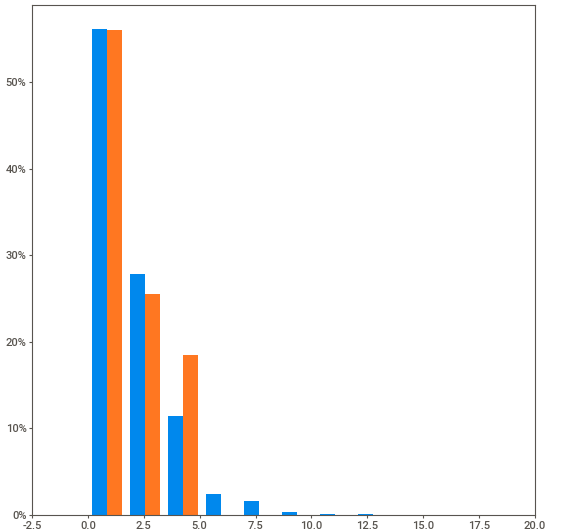
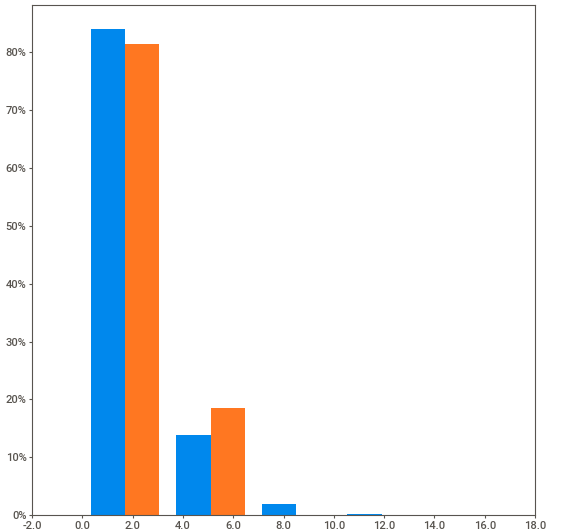
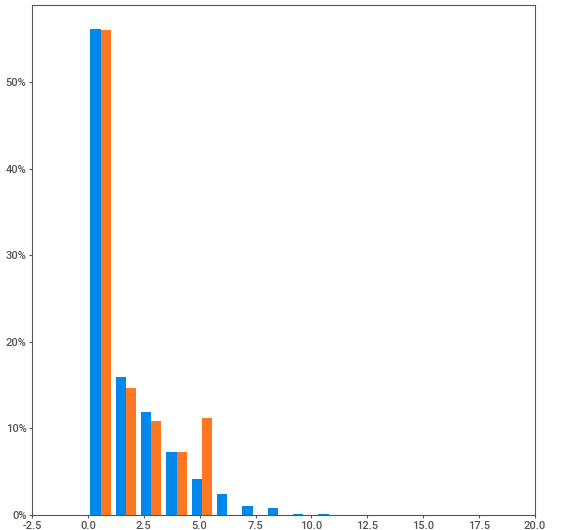
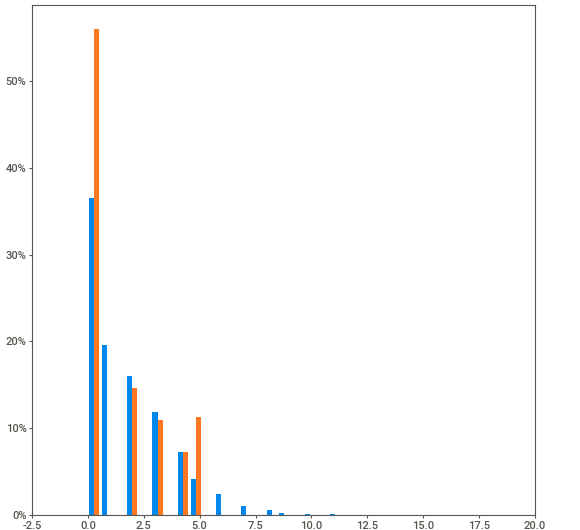
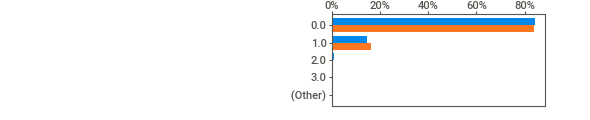
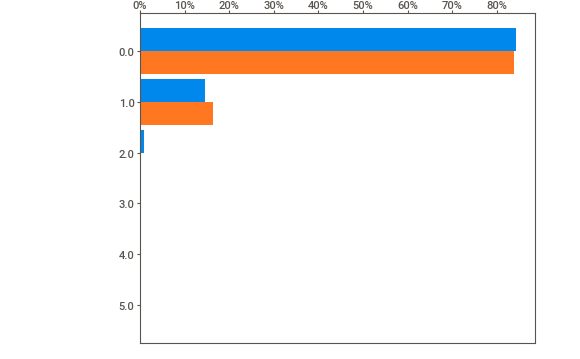
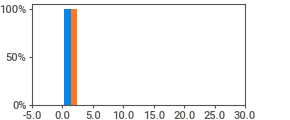
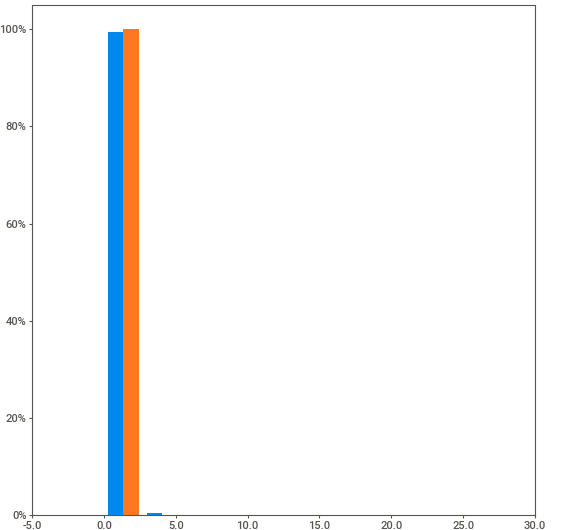
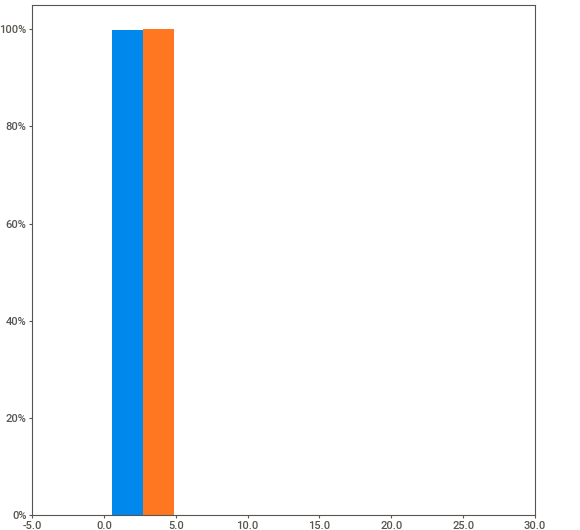
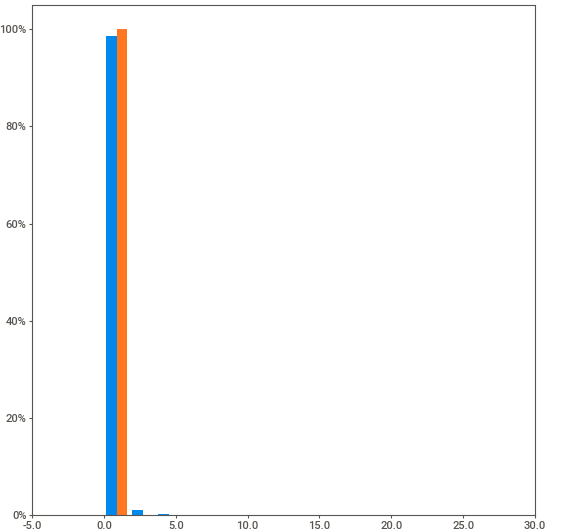
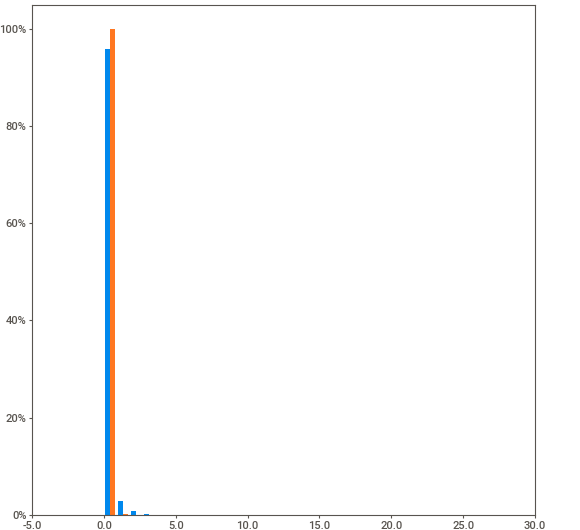
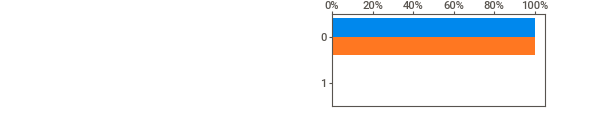
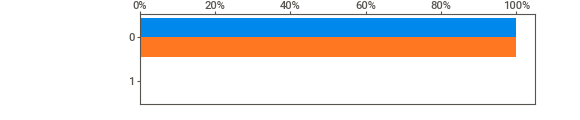
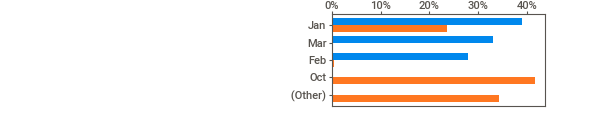
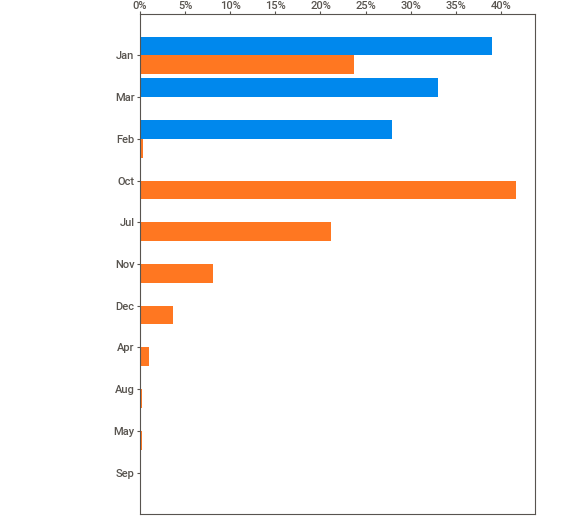
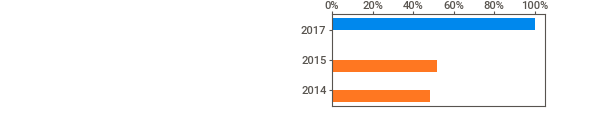
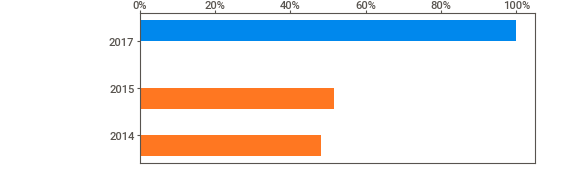
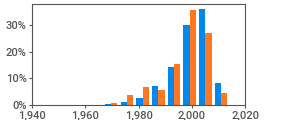
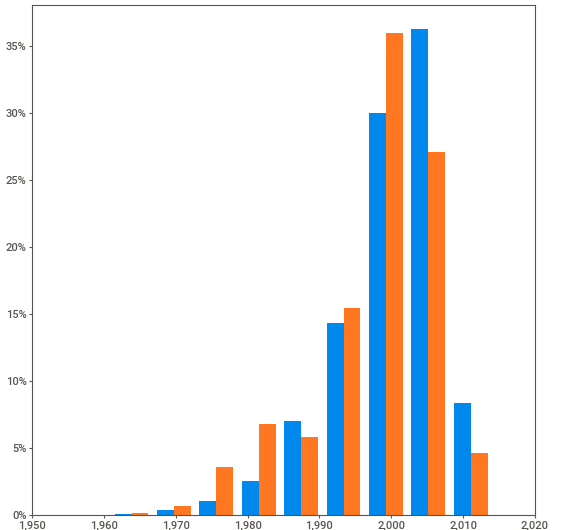
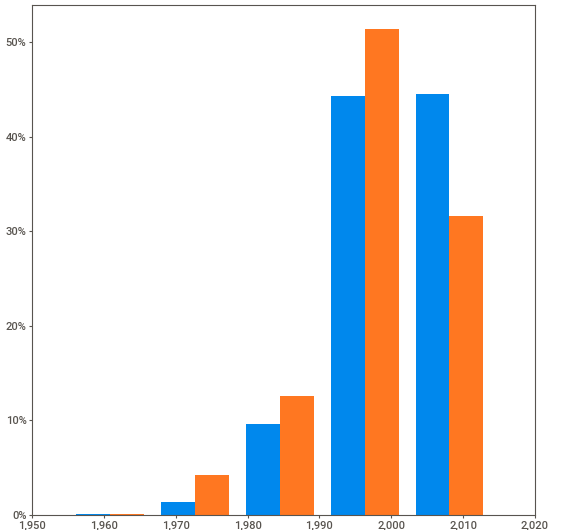
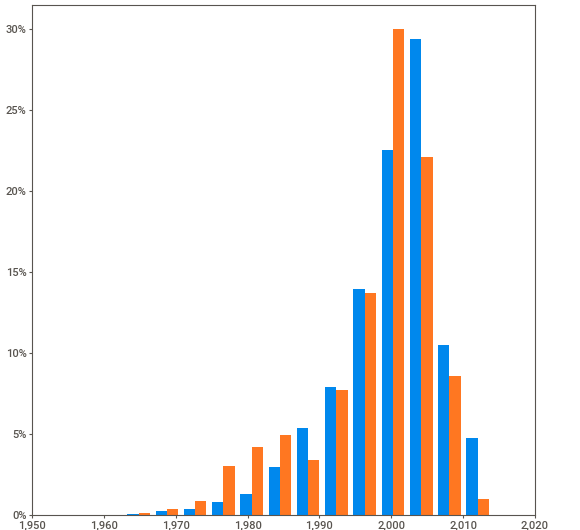
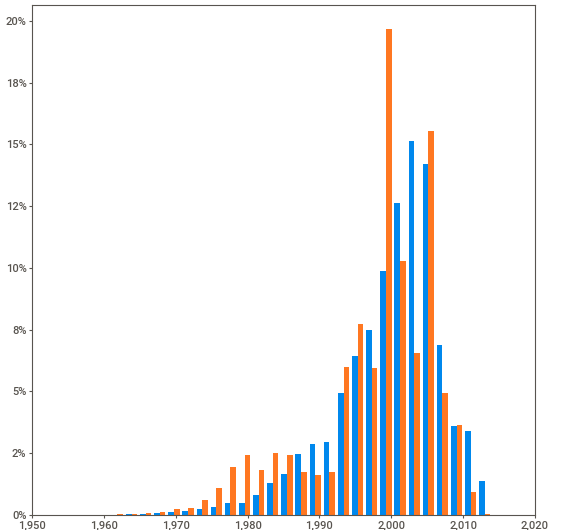
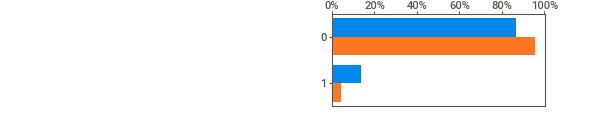
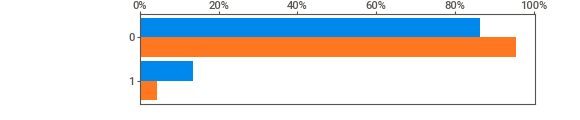
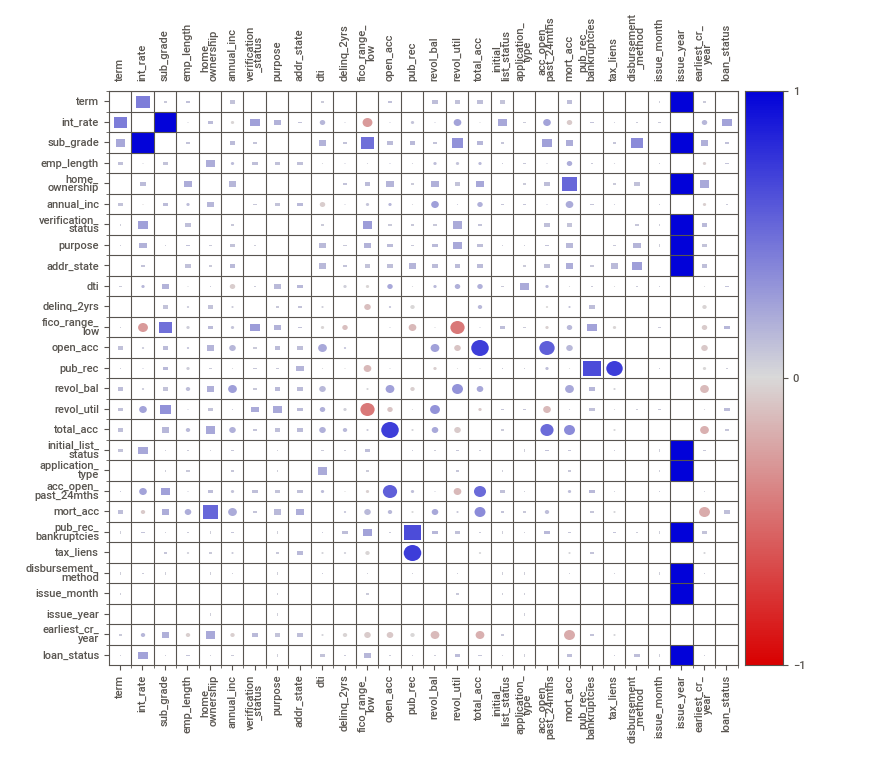
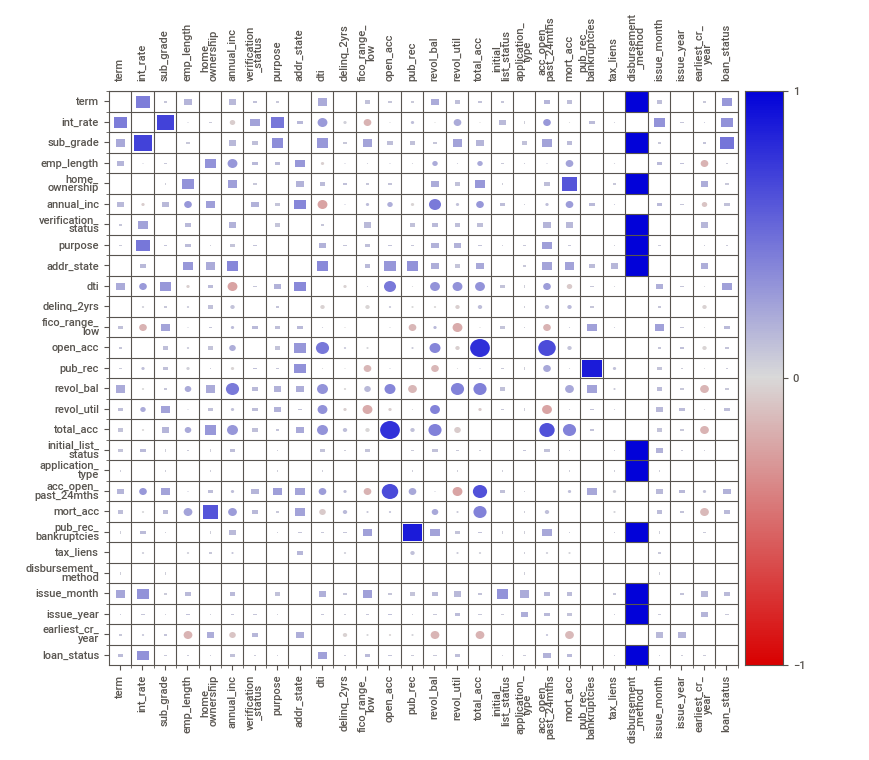

In [8]:
feature_config = sv.FeatureConfig() #,force_text=[""]
my_report = sv.compare([real_data, "Real Data"], [synthetic_data, "Synthetic Data"], feat_cfg=feature_config)
my_report.show_notebook( 
            layout='widescreen', 
            scale=None)